In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
import pickle
import scipy
import time
import tempfile
from tqdm import tqdm

from pyabc import (ABCSMC, RV,
                   PercentileDistanceFunction, DistanceFunction, sampler)
from pyabc import Distribution as abcDis

import sys 
sys.path.append('../../')
from model_comparison.utils import *
from model_comparison.mdns import *
from model_comparison.models import PoissonModel, NegativeBinomialModel

from delfi.distribution.mixture import MoG
%matplotlib inline

In [2]:
mpl_params = {'legend.fontsize': 14,
              'legend.frameon': False,
                      'axes.titlesize': 20,
                      'axes.labelsize': 17,
                      'xtick.labelsize': 12,
                      'ytick.labelsize': 12,
             'figure.figsize' : (18, 5)}

mpl.rcParams.update(mpl_params)

## Set up models

In [3]:
seed = 3
rng = np.random.RandomState(seed=seed)
time_stamp = time.strftime('%Y%m%d%H%M_')
figure_folder = '../figures/'

In [10]:
sample_size = 10
ntest = 100

k2 = 2.
theta2 = 1.0

k3 = 2.
theta3 = 2. 

# then the scale of the Gamma prior for the Poisson is given by
theta1 = 2.0
k1 = (k2 * theta2 * k3 * theta3) / theta1
print(k1)


model_poisson = PoissonModel(sample_size=sample_size, seed=seed, n_workers=1)
model_nb = NegativeBinomialModel(sample_size=sample_size, seed=seed, n_workers=1)

4.0


In [11]:
# from Gamma prior for Poisson 
prior_lam = scipy.stats.gamma(a=k1, scale=theta1)
prior_k = scipy.stats.gamma(a=k2, scale=theta2)
prior_theta = scipy.stats.gamma(a=k3, scale=theta3)

## Test data set 

In [12]:
n = ntest
params_poi_test = prior_lam.rvs(size=int(n / 2))
params_nb_test = np.vstack((prior_k.rvs(size=int(n / 2)), 
                       prior_theta.rvs(size=int(n / 2)))).T

In [13]:
data_poi_test = model_poisson.gen(params_poi_test)
data_nb_test = model_nb.gen(params_nb_test)

In [14]:
stats_poi_test = np.array([data_poi_test.mean(axis=1), data_poi_test.var(axis=1)]).T
stats_nb_test = np.array([data_nb_test.mean(axis=1), data_nb_test.var(axis=1)]).T

## PyABC SMC

In [15]:
# Define models oin pyabc style 
def model_1(parameters): 
    x = model_poisson.gen([parameters.lam])
    return {'y': np.array([x.mean(), x.var()])}

def model_2(parameters): 
    x = model_nb.gen([[parameters.k, parameters.theta]])
    return {'y': np.array([x.mean(), x.var()])}

# priors
prior1 = abcDis.from_dictionary_of_dictionaries(dict(lam={'type': 'gamma', 'kwargs': {'a':k1, 'scale': theta1}}))

prior2 = abcDis.from_dictionary_of_dictionaries(dict(k={'type': 'gamma', 'kwargs': {'a':k2, 'scale': theta2}}, 
                                                     theta={'type': 'gamma', 'kwargs': {'a':k3, 'scale': theta3}}))

models = [model_1, model_2]
parameter_priors = [prior1, prior2]

class MyDist(DistanceFunction): 
    
    def __call__(self, x, y): 
        return np.power(x['y'] - y['y'], 2).mean()      
    
    
class MyModelPrior(RV): 
    
    def rvs(self, *args, **kwargs):
        model_idx_vector = self.distribution.rvs(*args, **kwargs)[0]
        return np.where(model_idx_vector)[0][0]
    
    def pmf(self, x, *args, **kwargs):
        xv = [0, 0]
        xv[x] = 1
        return self.distribution.pmf(xv, *args, **kwargs)
        

## SMC with single round = rejection sampling

In [18]:
test_set = np.vstack((stats_poi_test, stats_nb_test))
phat_rej = np.zeros((ntest, 2))
model_prior = MyModelPrior.from_dictionary({'type': 'multinomial', 'kwargs': {'n': 1, 'p': [0.5, 0.5]}})
ns_rej = 0

for ii in tqdm.tqdm(range(ntest)): 
    sxo = test_set[ii, ]

    # We plug all the ABC options together
    abc = ABCSMC(
        models, parameter_priors, MyDist(), model_prior=model_prior,
         sampler=sampler.SingleCoreSampler())

    # and we define where to store the results
    db_path = ("sqlite:///" +
               os.path.join(tempfile.gettempdir(), "test.db"))
    abc_id = abc.new(db_path, {"y": sxo})
    history = abc.run(minimum_epsilon=0.05, max_nr_populations=1)
    model_probabilities = history.get_model_probabilities()
    print(history.total_nr_simulations)
    ns_rej += history.total_nr_simulations
    ppoi = model_probabilities[0][0]
    phat_rej[ii, 0] = ppoi
    phat_rej[ii, 1] = 1 - ppoi
    
print(ns_rej)


  0%|          | 0/100 [00:00<?, ?it/s]INFO:Epsilon:initial epsilon is 45.276525
INFO:History:Start <ABCSMC(id=124, start_time=2018-05-23 13:48:56.059765, end_time=None)>
INFO:ABC:t:0 eps:45.276525
INFO:History:Done <ABCSMC(id=124, start_time=2018-05-23 13:48:56.059765, end_time=2018-05-23 13:48:56.289987)>

  1%|          | 1/100 [00:00<00:30,  3.23it/s]INFO:Epsilon:initial epsilon is 24.135925000000004
INFO:History:Start <ABCSMC(id=125, start_time=2018-05-23 13:48:56.363823, end_time=None)>
INFO:ABC:t:0 eps:24.135925000000004


197


INFO:History:Done <ABCSMC(id=125, start_time=2018-05-23 13:48:56.363823, end_time=2018-05-23 13:48:56.593977)>

  2%|▏         | 2/100 [00:00<00:30,  3.26it/s]INFO:Epsilon:initial epsilon is 22.641249999999985
INFO:History:Start <ABCSMC(id=126, start_time=2018-05-23 13:48:56.664046, end_time=None)>
INFO:ABC:t:0 eps:22.641249999999985


204


INFO:History:Done <ABCSMC(id=126, start_time=2018-05-23 13:48:56.664046, end_time=2018-05-23 13:48:56.925914)>

  3%|▎         | 3/100 [00:00<00:30,  3.18it/s]INFO:Epsilon:initial epsilon is 23.49952499999999
INFO:History:Start <ABCSMC(id=127, start_time=2018-05-23 13:48:57.010883, end_time=None)>
INFO:ABC:t:0 eps:23.49952499999999


206


INFO:History:Done <ABCSMC(id=127, start_time=2018-05-23 13:48:57.010883, end_time=2018-05-23 13:48:57.260407)>

  4%|▍         | 4/100 [00:01<00:30,  3.12it/s]INFO:Epsilon:initial epsilon is 19.899999999999988
INFO:History:Start <ABCSMC(id=128, start_time=2018-05-23 13:48:57.334271, end_time=None)>
INFO:ABC:t:0 eps:19.899999999999988


210


INFO:History:Done <ABCSMC(id=128, start_time=2018-05-23 13:48:57.334271, end_time=2018-05-23 13:48:57.585716)>

  5%|▌         | 5/100 [00:01<00:30,  3.11it/s]INFO:Epsilon:initial epsilon is 31.652649999999998
INFO:History:Start <ABCSMC(id=129, start_time=2018-05-23 13:48:57.656008, end_time=None)>
INFO:ABC:t:0 eps:31.652649999999998


196


INFO:History:Done <ABCSMC(id=129, start_time=2018-05-23 13:48:57.656008, end_time=2018-05-23 13:48:57.923680)>

  6%|▌         | 6/100 [00:01<00:30,  3.06it/s]INFO:Epsilon:initial epsilon is 41.76792499999999
INFO:History:Start <ABCSMC(id=130, start_time=2018-05-23 13:48:57.995581, end_time=None)>
INFO:ABC:t:0 eps:41.76792499999999


250


INFO:History:Done <ABCSMC(id=130, start_time=2018-05-23 13:48:57.995581, end_time=2018-05-23 13:48:58.225117)>

  7%|▋         | 7/100 [00:02<00:29,  3.13it/s]INFO:Epsilon:initial epsilon is 30.613324999999982
INFO:History:Start <ABCSMC(id=131, start_time=2018-05-23 13:48:58.299094, end_time=None)>
INFO:ABC:t:0 eps:30.613324999999982


200



INFO:History:Done <ABCSMC(id=131, start_time=2018-05-23 13:48:58.299094, end_time=2018-05-23 13:48:58.557999)>
  8%|▊         | 8/100 [00:02<00:29,  3.07it/s]INFO:Epsilon:initial epsilon is 34.625124999999954
INFO:History:Start <ABCSMC(id=132, start_time=2018-05-23 13:48:58.646511, end_time=None)>
INFO:ABC:t:0 eps:34.625124999999954


190


INFO:History:Done <ABCSMC(id=132, start_time=2018-05-23 13:48:58.646511, end_time=2018-05-23 13:48:58.917227)>
  9%|▉         | 9/100 [00:02<00:30,  3.00it/s]INFO:Epsilon:initial epsilon is 30.581524999999978
INFO:History:Start <ABCSMC(id=133, start_time=2018-05-23 13:48:59.000404, end_time=None)>
INFO:ABC:t:0 eps:30.581524999999978


216


INFO:History:Done <ABCSMC(id=133, start_time=2018-05-23 13:48:59.000404, end_time=2018-05-23 13:48:59.229100)>
 10%|█         | 10/100 [00:03<00:29,  3.06it/s]INFO:Epsilon:initial epsilon is 28.83864999999997


173


INFO:History:Start <ABCSMC(id=134, start_time=2018-05-23 13:48:59.436336, end_time=None)>
INFO:ABC:t:0 eps:28.83864999999997
INFO:History:Done <ABCSMC(id=134, start_time=2018-05-23 13:48:59.436336, end_time=2018-05-23 13:48:59.702464)>
 11%|█         | 11/100 [00:03<00:33,  2.69it/s]INFO:Epsilon:initial epsilon is 22.895124999999982
INFO:History:Start <ABCSMC(id=135, start_time=2018-05-23 13:48:59.778771, end_time=None)>
INFO:ABC:t:0 eps:22.895124999999982


171


INFO:History:Done <ABCSMC(id=135, start_time=2018-05-23 13:48:59.778771, end_time=2018-05-23 13:49:00.044782)>
 12%|█▏        | 12/100 [00:04<00:32,  2.75it/s]INFO:Epsilon:initial epsilon is 40.88812500000001
INFO:History:Start <ABCSMC(id=136, start_time=2018-05-23 13:49:00.128443, end_time=None)>
INFO:ABC:t:0 eps:40.88812500000001


232


INFO:History:Done <ABCSMC(id=136, start_time=2018-05-23 13:49:00.128443, end_time=2018-05-23 13:49:00.368813)>
 13%|█▎        | 13/100 [00:04<00:30,  2.85it/s]INFO:Epsilon:initial epsilon is 26.41732499999999
INFO:History:Start <ABCSMC(id=137, start_time=2018-05-23 13:49:00.443766, end_time=None)>
INFO:ABC:t:0 eps:26.41732499999999


190


INFO:History:Done <ABCSMC(id=137, start_time=2018-05-23 13:49:00.443766, end_time=2018-05-23 13:49:00.682513)>
 14%|█▍        | 14/100 [00:04<00:29,  2.95it/s]INFO:Epsilon:initial epsilon is 17.466399999999954
INFO:History:Start <ABCSMC(id=138, start_time=2018-05-23 13:49:00.757625, end_time=None)>
INFO:ABC:t:0 eps:17.466399999999954


200


INFO:History:Done <ABCSMC(id=138, start_time=2018-05-23 13:49:00.757625, end_time=2018-05-23 13:49:01.022965)>
 15%|█▌        | 15/100 [00:05<00:28,  2.94it/s]INFO:Epsilon:initial epsilon is 25.062724999999936
INFO:History:Start <ABCSMC(id=139, start_time=2018-05-23 13:49:01.105486, end_time=None)>
INFO:ABC:t:0 eps:25.062724999999936


223


INFO:History:Done <ABCSMC(id=139, start_time=2018-05-23 13:49:01.105486, end_time=2018-05-23 13:49:01.383617)>
 16%|█▌        | 16/100 [00:05<00:29,  2.87it/s]INFO:Epsilon:initial epsilon is 26.401599999999995
INFO:History:Start <ABCSMC(id=140, start_time=2018-05-23 13:49:01.483116, end_time=None)>
INFO:ABC:t:0 eps:26.401599999999995


191


INFO:History:Done <ABCSMC(id=140, start_time=2018-05-23 13:49:01.483116, end_time=2018-05-23 13:49:01.705344)>
 17%|█▋        | 17/100 [00:05<00:28,  2.96it/s]INFO:Epsilon:initial epsilon is 27.871599999999983
INFO:History:Start <ABCSMC(id=141, start_time=2018-05-23 13:49:01.775866, end_time=None)>
INFO:ABC:t:0 eps:27.871599999999983


194


INFO:History:Done <ABCSMC(id=141, start_time=2018-05-23 13:49:01.775866, end_time=2018-05-23 13:49:02.013098)>
 18%|█▊        | 18/100 [00:06<00:26,  3.04it/s]INFO:Epsilon:initial epsilon is 28.129324999999938
INFO:History:Start <ABCSMC(id=142, start_time=2018-05-23 13:49:02.082026, end_time=None)>
INFO:ABC:t:0 eps:28.129324999999938


216


INFO:History:Done <ABCSMC(id=142, start_time=2018-05-23 13:49:02.082026, end_time=2018-05-23 13:49:02.323389)>
 19%|█▉        | 19/100 [00:06<00:26,  3.09it/s]INFO:Epsilon:initial epsilon is 19.628124999999997
INFO:History:Start <ABCSMC(id=143, start_time=2018-05-23 13:49:02.396525, end_time=None)>
INFO:ABC:t:0 eps:19.628124999999997


232


INFO:History:Done <ABCSMC(id=143, start_time=2018-05-23 13:49:02.396525, end_time=2018-05-23 13:49:02.743193)>
 20%|██        | 20/100 [00:06<00:28,  2.84it/s]INFO:Epsilon:initial epsilon is 22.213599999999992
INFO:History:Start <ABCSMC(id=144, start_time=2018-05-23 13:49:02.815377, end_time=None)>
INFO:ABC:t:0 eps:22.213599999999992


214


INFO:History:Done <ABCSMC(id=144, start_time=2018-05-23 13:49:02.815377, end_time=2018-05-23 13:49:03.052912)>
 21%|██        | 21/100 [00:07<00:26,  2.95it/s]INFO:Epsilon:initial epsilon is 25.588324999999987
INFO:History:Start <ABCSMC(id=145, start_time=2018-05-23 13:49:03.121801, end_time=None)>
INFO:ABC:t:0 eps:25.588324999999987


218


INFO:History:Done <ABCSMC(id=145, start_time=2018-05-23 13:49:03.121801, end_time=2018-05-23 13:49:03.353920)>
 22%|██▏       | 22/100 [00:07<00:25,  3.05it/s]INFO:Epsilon:initial epsilon is 22.97532499999995
INFO:History:Start <ABCSMC(id=146, start_time=2018-05-23 13:49:03.428274, end_time=None)>
INFO:ABC:t:0 eps:22.97532499999995


227


INFO:History:Done <ABCSMC(id=146, start_time=2018-05-23 13:49:03.428274, end_time=2018-05-23 13:49:03.669400)>
 23%|██▎       | 23/100 [00:07<00:24,  3.09it/s]INFO:Epsilon:initial epsilon is 43.45192499999998
INFO:History:Start <ABCSMC(id=147, start_time=2018-05-23 13:49:03.743346, end_time=None)>
INFO:ABC:t:0 eps:43.45192499999998


227


INFO:History:Done <ABCSMC(id=147, start_time=2018-05-23 13:49:03.743346, end_time=2018-05-23 13:49:03.975517)>
 24%|██▍       | 24/100 [00:07<00:24,  3.14it/s]INFO:Epsilon:initial epsilon is 56.4404
INFO:History:Start <ABCSMC(id=148, start_time=2018-05-23 13:49:04.048917, end_time=None)>
INFO:ABC:t:0 eps:56.4404


211


INFO:History:Done <ABCSMC(id=148, start_time=2018-05-23 13:49:04.048917, end_time=2018-05-23 13:49:04.291143)>
 25%|██▌       | 25/100 [00:08<00:23,  3.14it/s]INFO:Epsilon:initial epsilon is 24.917049999999993
INFO:History:Start <ABCSMC(id=149, start_time=2018-05-23 13:49:04.370853, end_time=None)>
INFO:ABC:t:0 eps:24.917049999999993


231


INFO:History:Done <ABCSMC(id=149, start_time=2018-05-23 13:49:04.370853, end_time=2018-05-23 13:49:04.610285)>
 26%|██▌       | 26/100 [00:08<00:23,  3.15it/s]INFO:Epsilon:initial epsilon is 47.95312499999998
INFO:History:Start <ABCSMC(id=150, start_time=2018-05-23 13:49:04.683700, end_time=None)>
INFO:ABC:t:0 eps:47.95312499999998


211


INFO:History:Done <ABCSMC(id=150, start_time=2018-05-23 13:49:04.683700, end_time=2018-05-23 13:49:04.910509)>
 27%|██▋       | 27/100 [00:08<00:22,  3.20it/s]INFO:Epsilon:initial epsilon is 21.59759999999998
INFO:History:Start <ABCSMC(id=151, start_time=2018-05-23 13:49:04.987574, end_time=None)>
INFO:ABC:t:0 eps:21.59759999999998


186


INFO:History:Done <ABCSMC(id=151, start_time=2018-05-23 13:49:04.987574, end_time=2018-05-23 13:49:05.276125)>
 28%|██▊       | 28/100 [00:09<00:23,  3.04it/s]INFO:Epsilon:initial epsilon is 16.55872499999999
INFO:History:Start <ABCSMC(id=152, start_time=2018-05-23 13:49:05.347845, end_time=None)>
INFO:ABC:t:0 eps:16.55872499999999


171


INFO:History:Done <ABCSMC(id=152, start_time=2018-05-23 13:49:05.347845, end_time=2018-05-23 13:49:05.587050)>
 29%|██▉       | 29/100 [00:09<00:22,  3.10it/s]INFO:Epsilon:initial epsilon is 58.432399999999916
INFO:History:Start <ABCSMC(id=153, start_time=2018-05-23 13:49:05.658345, end_time=None)>
INFO:ABC:t:0 eps:58.432399999999916


236


INFO:History:Done <ABCSMC(id=153, start_time=2018-05-23 13:49:05.658345, end_time=2018-05-23 13:49:05.879218)>
 30%|███       | 30/100 [00:09<00:21,  3.18it/s]INFO:Epsilon:initial epsilon is 21.391849999999984
INFO:History:Start <ABCSMC(id=154, start_time=2018-05-23 13:49:06.046371, end_time=None)>
INFO:ABC:t:0 eps:21.391849999999984


176


INFO:History:Done <ABCSMC(id=154, start_time=2018-05-23 13:49:06.046371, end_time=2018-05-23 13:49:06.277848)>
 31%|███       | 31/100 [00:10<00:23,  2.95it/s]INFO:Epsilon:initial epsilon is 18.139999999999993
INFO:History:Start <ABCSMC(id=155, start_time=2018-05-23 13:49:06.349250, end_time=None)>
INFO:ABC:t:0 eps:18.139999999999993


201


INFO:History:Done <ABCSMC(id=155, start_time=2018-05-23 13:49:06.349250, end_time=2018-05-23 13:49:06.563696)>
 32%|███▏      | 32/100 [00:10<00:22,  3.09it/s]INFO:Epsilon:initial epsilon is 20.634724999999978
INFO:History:Start <ABCSMC(id=156, start_time=2018-05-23 13:49:06.634348, end_time=None)>
INFO:ABC:t:0 eps:20.634724999999978


187


INFO:History:Done <ABCSMC(id=156, start_time=2018-05-23 13:49:06.634348, end_time=2018-05-23 13:49:06.870288)>
 33%|███▎      | 33/100 [00:10<00:21,  3.15it/s]INFO:Epsilon:initial epsilon is 23.155524999999994
INFO:History:Start <ABCSMC(id=157, start_time=2018-05-23 13:49:06.941166, end_time=None)>
INFO:ABC:t:0 eps:23.155524999999994


200


INFO:History:Done <ABCSMC(id=157, start_time=2018-05-23 13:49:06.941166, end_time=2018-05-23 13:49:07.164205)>
 34%|███▍      | 34/100 [00:11<00:20,  3.21it/s]INFO:Epsilon:initial epsilon is 14.69632499999994
INFO:History:Start <ABCSMC(id=158, start_time=2018-05-23 13:49:07.235890, end_time=None)>
INFO:ABC:t:0 eps:14.69632499999994


179


INFO:History:Done <ABCSMC(id=158, start_time=2018-05-23 13:49:07.235890, end_time=2018-05-23 13:49:07.462963)>
 35%|███▌      | 35/100 [00:11<00:19,  3.25it/s]INFO:Epsilon:initial epsilon is 80.11072499999999
INFO:History:Start <ABCSMC(id=159, start_time=2018-05-23 13:49:07.536919, end_time=None)>
INFO:ABC:t:0 eps:80.11072499999999


214


INFO:History:Done <ABCSMC(id=159, start_time=2018-05-23 13:49:07.536919, end_time=2018-05-23 13:49:07.770093)>
 36%|███▌      | 36/100 [00:11<00:19,  3.26it/s]INFO:Epsilon:initial epsilon is 19.002399999999998
INFO:History:Start <ABCSMC(id=160, start_time=2018-05-23 13:49:07.843545, end_time=None)>
INFO:ABC:t:0 eps:19.002399999999998


185


INFO:History:Done <ABCSMC(id=160, start_time=2018-05-23 13:49:07.843545, end_time=2018-05-23 13:49:08.084350)>
 37%|███▋      | 37/100 [00:12<00:19,  3.23it/s]INFO:Epsilon:initial epsilon is 24.342124999999996
INFO:History:Start <ABCSMC(id=161, start_time=2018-05-23 13:49:08.164288, end_time=None)>
INFO:ABC:t:0 eps:24.342124999999996


204


INFO:History:Done <ABCSMC(id=161, start_time=2018-05-23 13:49:08.164288, end_time=2018-05-23 13:49:08.461900)>
 38%|███▊      | 38/100 [00:12<00:20,  3.03it/s]INFO:Epsilon:initial epsilon is 546.1399999999998
INFO:History:Start <ABCSMC(id=162, start_time=2018-05-23 13:49:08.534714, end_time=None)>
INFO:ABC:t:0 eps:546.1399999999998


178


INFO:History:Done <ABCSMC(id=162, start_time=2018-05-23 13:49:08.534714, end_time=2018-05-23 13:49:08.784289)>
 39%|███▉      | 39/100 [00:12<00:19,  3.05it/s]INFO:Epsilon:initial epsilon is 24.11372499999999
INFO:History:Start <ABCSMC(id=163, start_time=2018-05-23 13:49:08.857029, end_time=None)>
INFO:ABC:t:0 eps:24.11372499999999


222


INFO:History:Done <ABCSMC(id=163, start_time=2018-05-23 13:49:08.857029, end_time=2018-05-23 13:49:09.087489)>
 40%|████      | 40/100 [00:13<00:19,  3.13it/s]INFO:Epsilon:initial epsilon is 43.432799999999965
INFO:History:Start <ABCSMC(id=164, start_time=2018-05-23 13:49:09.157491, end_time=None)>
INFO:ABC:t:0 eps:43.432799999999965


195


INFO:History:Done <ABCSMC(id=164, start_time=2018-05-23 13:49:09.157491, end_time=2018-05-23 13:49:09.392472)>
 41%|████      | 41/100 [00:13<00:18,  3.16it/s]INFO:Epsilon:initial epsilon is 29.47192499999991
INFO:History:Start <ABCSMC(id=165, start_time=2018-05-23 13:49:09.466935, end_time=None)>
INFO:ABC:t:0 eps:29.47192499999991


199


INFO:History:Done <ABCSMC(id=165, start_time=2018-05-23 13:49:09.466935, end_time=2018-05-23 13:49:09.720916)>
 42%|████▏     | 42/100 [00:13<00:18,  3.13it/s]INFO:Epsilon:initial epsilon is 20.001724999999997
INFO:History:Start <ABCSMC(id=166, start_time=2018-05-23 13:49:09.793511, end_time=None)>
INFO:ABC:t:0 eps:20.001724999999997


250


INFO:History:Done <ABCSMC(id=166, start_time=2018-05-23 13:49:09.793511, end_time=2018-05-23 13:49:10.034874)>
 43%|████▎     | 43/100 [00:14<00:18,  3.14it/s]INFO:Epsilon:initial epsilon is 27.71772499999999
INFO:History:Start <ABCSMC(id=167, start_time=2018-05-23 13:49:10.110521, end_time=None)>
INFO:ABC:t:0 eps:27.71772499999999


215


INFO:History:Done <ABCSMC(id=167, start_time=2018-05-23 13:49:10.110521, end_time=2018-05-23 13:49:10.329497)>
 44%|████▍     | 44/100 [00:14<00:17,  3.22it/s]INFO:Epsilon:initial epsilon is 27.081124999999954
INFO:History:Start <ABCSMC(id=168, start_time=2018-05-23 13:49:10.402647, end_time=None)>
INFO:ABC:t:0 eps:27.081124999999954


161


INFO:History:Done <ABCSMC(id=168, start_time=2018-05-23 13:49:10.402647, end_time=2018-05-23 13:49:10.647400)>
 45%|████▌     | 45/100 [00:14<00:17,  3.19it/s]INFO:Epsilon:initial epsilon is 17.076324999999997
INFO:History:Start <ABCSMC(id=169, start_time=2018-05-23 13:49:10.725317, end_time=None)>
INFO:ABC:t:0 eps:17.076324999999997


202


INFO:History:Done <ABCSMC(id=169, start_time=2018-05-23 13:49:10.725317, end_time=2018-05-23 13:49:10.990857)>
 46%|████▌     | 46/100 [00:15<00:17,  3.10it/s]INFO:Epsilon:initial epsilon is 22.515599999999996
INFO:History:Start <ABCSMC(id=170, start_time=2018-05-23 13:49:11.069739, end_time=None)>
INFO:ABC:t:0 eps:22.515599999999996


213


INFO:History:Done <ABCSMC(id=170, start_time=2018-05-23 13:49:11.069739, end_time=2018-05-23 13:49:11.326473)>
 47%|████▋     | 47/100 [00:15<00:19,  2.75it/s]INFO:Epsilon:initial epsilon is 35.91079999999997
INFO:History:Start <ABCSMC(id=171, start_time=2018-05-23 13:49:11.528478, end_time=None)>


202


INFO:ABC:t:0 eps:35.91079999999997
INFO:History:Done <ABCSMC(id=171, start_time=2018-05-23 13:49:11.528478, end_time=2018-05-23 13:49:11.772182)>
 48%|████▊     | 48/100 [00:15<00:18,  2.85it/s]INFO:Epsilon:initial epsilon is 35.73524999999998
INFO:History:Start <ABCSMC(id=172, start_time=2018-05-23 13:49:11.846064, end_time=None)>
INFO:ABC:t:0 eps:35.73524999999998


182


INFO:History:Done <ABCSMC(id=172, start_time=2018-05-23 13:49:11.846064, end_time=2018-05-23 13:49:12.072741)>
 49%|████▉     | 49/100 [00:16<00:17,  2.98it/s]INFO:Epsilon:initial epsilon is 31.896799999999935
INFO:History:Start <ABCSMC(id=173, start_time=2018-05-23 13:49:12.145637, end_time=None)>
INFO:ABC:t:0 eps:31.896799999999935


166


INFO:History:Done <ABCSMC(id=173, start_time=2018-05-23 13:49:12.145637, end_time=2018-05-23 13:49:12.387431)>
 50%|█████     | 50/100 [00:16<00:16,  3.02it/s]INFO:Epsilon:initial epsilon is 27.56072499999999
INFO:History:Start <ABCSMC(id=174, start_time=2018-05-23 13:49:12.468346, end_time=None)>
INFO:ABC:t:0 eps:27.56072499999999


203


INFO:History:Done <ABCSMC(id=174, start_time=2018-05-23 13:49:12.468346, end_time=2018-05-23 13:49:12.729719)>
 51%|█████     | 51/100 [00:16<00:16,  3.00it/s]INFO:Epsilon:initial epsilon is 563.5643999999996
INFO:History:Start <ABCSMC(id=175, start_time=2018-05-23 13:49:12.818698, end_time=None)>
INFO:ABC:t:0 eps:563.5643999999996


182


INFO:History:Done <ABCSMC(id=175, start_time=2018-05-23 13:49:12.818698, end_time=2018-05-23 13:49:13.071520)>
 52%|█████▏    | 52/100 [00:17<00:16,  2.98it/s]INFO:Epsilon:initial epsilon is 36.38804999999996
INFO:History:Start <ABCSMC(id=176, start_time=2018-05-23 13:49:13.149473, end_time=None)>
INFO:ABC:t:0 eps:36.38804999999996


206


INFO:History:Done <ABCSMC(id=176, start_time=2018-05-23 13:49:13.149473, end_time=2018-05-23 13:49:13.378040)>
 53%|█████▎    | 53/100 [00:17<00:15,  3.06it/s]INFO:Epsilon:initial epsilon is 3292.3735250000004
INFO:History:Start <ABCSMC(id=177, start_time=2018-05-23 13:49:13.453895, end_time=None)>
INFO:ABC:t:0 eps:3292.3735250000004


157


INFO:History:Done <ABCSMC(id=177, start_time=2018-05-23 13:49:13.453895, end_time=2018-05-23 13:49:13.715477)>
 54%|█████▍    | 54/100 [00:17<00:15,  3.03it/s]INFO:Epsilon:initial epsilon is 47.90812499999998
INFO:History:Start <ABCSMC(id=178, start_time=2018-05-23 13:49:13.791580, end_time=None)>
INFO:ABC:t:0 eps:47.90812499999998


234


INFO:History:Done <ABCSMC(id=178, start_time=2018-05-23 13:49:13.791580, end_time=2018-05-23 13:49:14.050768)>
 55%|█████▌    | 55/100 [00:18<00:14,  3.01it/s]INFO:Epsilon:initial epsilon is 142.49124999999995
INFO:History:Start <ABCSMC(id=179, start_time=2018-05-23 13:49:14.128587, end_time=None)>
INFO:ABC:t:0 eps:142.49124999999995


226


INFO:History:Done <ABCSMC(id=179, start_time=2018-05-23 13:49:14.128587, end_time=2018-05-23 13:49:14.478964)>
 56%|█████▌    | 56/100 [00:18<00:15,  2.78it/s]INFO:Epsilon:initial epsilon is 39481.220799999996
INFO:History:Start <ABCSMC(id=180, start_time=2018-05-23 13:49:14.555404, end_time=None)>
INFO:ABC:t:0 eps:39481.220799999996


212


INFO:History:Done <ABCSMC(id=180, start_time=2018-05-23 13:49:14.555404, end_time=2018-05-23 13:49:14.792400)>
 57%|█████▋    | 57/100 [00:18<00:14,  2.89it/s]INFO:Epsilon:initial epsilon is 28.721524999999982
INFO:History:Start <ABCSMC(id=181, start_time=2018-05-23 13:49:14.864803, end_time=None)>
INFO:ABC:t:0 eps:28.721524999999982


208


INFO:History:Done <ABCSMC(id=181, start_time=2018-05-23 13:49:14.864803, end_time=2018-05-23 13:49:15.082401)>
 58%|█████▊    | 58/100 [00:19<00:13,  3.04it/s]INFO:Epsilon:initial epsilon is 1124.6864
INFO:History:Start <ABCSMC(id=182, start_time=2018-05-23 13:49:15.151890, end_time=None)>
INFO:ABC:t:0 eps:1124.6864


177


INFO:History:Done <ABCSMC(id=182, start_time=2018-05-23 13:49:15.151890, end_time=2018-05-23 13:49:15.373496)>
 59%|█████▉    | 59/100 [00:19<00:13,  3.15it/s]INFO:Epsilon:initial epsilon is 149.52545000000006
INFO:History:Start <ABCSMC(id=183, start_time=2018-05-23 13:49:15.443353, end_time=None)>
INFO:ABC:t:0 eps:149.52545000000006


178


INFO:History:Done <ABCSMC(id=183, start_time=2018-05-23 13:49:15.443353, end_time=2018-05-23 13:49:15.672340)>
 60%|██████    | 60/100 [00:19<00:12,  3.20it/s]INFO:Epsilon:initial epsilon is 95.124925
INFO:History:Start <ABCSMC(id=184, start_time=2018-05-23 13:49:15.745612, end_time=None)>
INFO:ABC:t:0 eps:95.124925


206


INFO:History:Done <ABCSMC(id=184, start_time=2018-05-23 13:49:15.745612, end_time=2018-05-23 13:49:15.977881)>
 61%|██████    | 61/100 [00:19<00:12,  3.22it/s]INFO:Epsilon:initial epsilon is 39.350725
INFO:History:Start <ABCSMC(id=185, start_time=2018-05-23 13:49:16.051181, end_time=None)>
INFO:ABC:t:0 eps:39.350725


172


INFO:History:Done <ABCSMC(id=185, start_time=2018-05-23 13:49:16.051181, end_time=2018-05-23 13:49:16.339791)>
 62%|██████▏   | 62/100 [00:20<00:12,  3.07it/s]INFO:Epsilon:initial epsilon is 1045.7908499999999
INFO:History:Start <ABCSMC(id=186, start_time=2018-05-23 13:49:16.413065, end_time=None)>
INFO:ABC:t:0 eps:1045.7908499999999


248


INFO:History:Done <ABCSMC(id=186, start_time=2018-05-23 13:49:16.413065, end_time=2018-05-23 13:49:16.649999)>
 63%|██████▎   | 63/100 [00:20<00:11,  3.11it/s]INFO:Epsilon:initial epsilon is 284.46385
INFO:History:Start <ABCSMC(id=187, start_time=2018-05-23 13:49:16.723641, end_time=None)>
INFO:ABC:t:0 eps:284.46385


205


INFO:History:Done <ABCSMC(id=187, start_time=2018-05-23 13:49:16.723641, end_time=2018-05-23 13:49:16.942548)>
 64%|██████▍   | 64/100 [00:20<00:11,  3.20it/s]INFO:Epsilon:initial epsilon is 499.37244999999984
INFO:History:Start <ABCSMC(id=188, start_time=2018-05-23 13:49:17.014646, end_time=None)>
INFO:ABC:t:0 eps:499.37244999999984


169


INFO:History:Done <ABCSMC(id=188, start_time=2018-05-23 13:49:17.014646, end_time=2018-05-23 13:49:17.352357)>
 65%|██████▌   | 65/100 [00:21<00:11,  2.92it/s]INFO:Epsilon:initial epsilon is 112.65812500000006
INFO:History:Start <ABCSMC(id=189, start_time=2018-05-23 13:49:17.427822, end_time=None)>
INFO:ABC:t:0 eps:112.65812500000006


186


INFO:History:Done <ABCSMC(id=189, start_time=2018-05-23 13:49:17.427822, end_time=2018-05-23 13:49:17.677627)>
 66%|██████▌   | 66/100 [00:21<00:11,  2.98it/s]INFO:Epsilon:initial epsilon is 1668.2007249999988
INFO:History:Start <ABCSMC(id=190, start_time=2018-05-23 13:49:17.746548, end_time=None)>
INFO:ABC:t:0 eps:1668.2007249999988


266


INFO:History:Done <ABCSMC(id=190, start_time=2018-05-23 13:49:17.746548, end_time=2018-05-23 13:49:17.983787)>
 67%|██████▋   | 67/100 [00:22<00:10,  3.05it/s]INFO:Epsilon:initial epsilon is 3128.8581249999993
INFO:History:Start <ABCSMC(id=191, start_time=2018-05-23 13:49:18.057719, end_time=None)>
INFO:ABC:t:0 eps:3128.8581249999993


160


INFO:History:Done <ABCSMC(id=191, start_time=2018-05-23 13:49:18.057719, end_time=2018-05-23 13:49:18.291481)>
 68%|██████▊   | 68/100 [00:22<00:10,  3.11it/s]INFO:Epsilon:initial epsilon is 23.946124999999967
INFO:History:Start <ABCSMC(id=192, start_time=2018-05-23 13:49:18.362776, end_time=None)>
INFO:ABC:t:0 eps:23.946124999999967


199


INFO:History:Done <ABCSMC(id=192, start_time=2018-05-23 13:49:18.362776, end_time=2018-05-23 13:49:18.596718)>
 69%|██████▉   | 69/100 [00:22<00:09,  3.16it/s]INFO:Epsilon:initial epsilon is 72.94904999999999
INFO:History:Start <ABCSMC(id=193, start_time=2018-05-23 13:49:18.668949, end_time=None)>
INFO:ABC:t:0 eps:72.94904999999999


217


INFO:History:Done <ABCSMC(id=193, start_time=2018-05-23 13:49:18.668949, end_time=2018-05-23 13:49:18.888836)>
 70%|███████   | 70/100 [00:22<00:09,  3.23it/s]INFO:Epsilon:initial epsilon is 41.94852499999998
INFO:History:Start <ABCSMC(id=194, start_time=2018-05-23 13:49:18.962266, end_time=None)>
INFO:ABC:t:0 eps:41.94852499999998


173


INFO:History:Done <ABCSMC(id=194, start_time=2018-05-23 13:49:18.962266, end_time=2018-05-23 13:49:19.197334)>
 71%|███████   | 71/100 [00:23<00:08,  3.23it/s]INFO:Epsilon:initial epsilon is 1665.1719999999991
INFO:History:Start <ABCSMC(id=195, start_time=2018-05-23 13:49:19.272423, end_time=None)>
INFO:ABC:t:0 eps:1665.1719999999991


181


INFO:History:Done <ABCSMC(id=195, start_time=2018-05-23 13:49:19.272423, end_time=2018-05-23 13:49:19.518585)>
 72%|███████▏  | 72/100 [00:23<00:08,  3.20it/s]INFO:Epsilon:initial epsilon is 59.26812499999998
INFO:History:Start <ABCSMC(id=196, start_time=2018-05-23 13:49:19.593009, end_time=None)>
INFO:ABC:t:0 eps:59.26812499999998


222


INFO:History:Done <ABCSMC(id=196, start_time=2018-05-23 13:49:19.593009, end_time=2018-05-23 13:49:19.830543)>
 73%|███████▎  | 73/100 [00:23<00:08,  3.20it/s]INFO:Epsilon:initial epsilon is 2538.9976
INFO:History:Start <ABCSMC(id=197, start_time=2018-05-23 13:49:19.904477, end_time=None)>
INFO:ABC:t:0 eps:2538.9976


227


INFO:History:Done <ABCSMC(id=197, start_time=2018-05-23 13:49:19.904477, end_time=2018-05-23 13:49:20.235863)>
 74%|███████▍  | 74/100 [00:24<00:08,  2.94it/s]INFO:Epsilon:initial epsilon is 2261.3351249999996
INFO:History:Start <ABCSMC(id=198, start_time=2018-05-23 13:49:20.310272, end_time=None)>
INFO:ABC:t:0 eps:2261.3351249999996


174


INFO:History:Done <ABCSMC(id=198, start_time=2018-05-23 13:49:20.310272, end_time=2018-05-23 13:49:20.554114)>
 75%|███████▌  | 75/100 [00:24<00:08,  3.00it/s]INFO:Epsilon:initial epsilon is 35.639999999999986
INFO:History:Start <ABCSMC(id=199, start_time=2018-05-23 13:49:20.626520, end_time=None)>
INFO:ABC:t:0 eps:35.639999999999986


195


INFO:History:Done <ABCSMC(id=199, start_time=2018-05-23 13:49:20.626520, end_time=2018-05-23 13:49:20.855318)>
 76%|███████▌  | 76/100 [00:24<00:07,  3.08it/s]INFO:Epsilon:initial epsilon is 59.818000000000005
INFO:History:Start <ABCSMC(id=200, start_time=2018-05-23 13:49:20.927976, end_time=None)>
INFO:ABC:t:0 eps:59.818000000000005


211


INFO:History:Done <ABCSMC(id=200, start_time=2018-05-23 13:49:20.927976, end_time=2018-05-23 13:49:21.155383)>
 77%|███████▋  | 77/100 [00:25<00:07,  3.16it/s]INFO:Epsilon:initial epsilon is 5429.686250000002
INFO:History:Start <ABCSMC(id=201, start_time=2018-05-23 13:49:21.228905, end_time=None)>
INFO:ABC:t:0 eps:5429.686250000002


199


INFO:History:Done <ABCSMC(id=201, start_time=2018-05-23 13:49:21.228905, end_time=2018-05-23 13:49:21.470724)>
 78%|███████▊  | 78/100 [00:25<00:06,  3.16it/s]INFO:Epsilon:initial epsilon is 14.117649999999989
INFO:History:Start <ABCSMC(id=202, start_time=2018-05-23 13:49:21.540168, end_time=None)>
INFO:ABC:t:0 eps:14.117649999999989


238


INFO:History:Done <ABCSMC(id=202, start_time=2018-05-23 13:49:21.540168, end_time=2018-05-23 13:49:21.772501)>
 79%|███████▉  | 79/100 [00:25<00:06,  3.21it/s]INFO:Epsilon:initial epsilon is 44.98625
INFO:History:Start <ABCSMC(id=203, start_time=2018-05-23 13:49:21.843110, end_time=None)>
INFO:ABC:t:0 eps:44.98625


236


INFO:History:Done <ABCSMC(id=203, start_time=2018-05-23 13:49:21.843110, end_time=2018-05-23 13:49:22.062452)>
 80%|████████  | 80/100 [00:26<00:06,  3.28it/s]INFO:Epsilon:initial epsilon is 16.350449999999988
INFO:History:Start <ABCSMC(id=204, start_time=2018-05-23 13:49:22.132396, end_time=None)>
INFO:ABC:t:0 eps:16.350449999999988


182


INFO:History:Done <ABCSMC(id=204, start_time=2018-05-23 13:49:22.132396, end_time=2018-05-23 13:49:22.356666)>
 81%|████████  | 81/100 [00:26<00:05,  3.31it/s]INFO:Epsilon:initial epsilon is 1411.091999999999
INFO:History:Start <ABCSMC(id=205, start_time=2018-05-23 13:49:22.426957, end_time=None)>
INFO:ABC:t:0 eps:1411.091999999999


206


INFO:History:Done <ABCSMC(id=205, start_time=2018-05-23 13:49:22.426957, end_time=2018-05-23 13:49:22.655147)>
 82%|████████▏ | 82/100 [00:26<00:05,  3.32it/s]INFO:Epsilon:initial epsilon is 43.89
INFO:History:Start <ABCSMC(id=206, start_time=2018-05-23 13:49:22.724514, end_time=None)>
INFO:ABC:t:0 eps:43.89


205


INFO:History:Done <ABCSMC(id=206, start_time=2018-05-23 13:49:22.724514, end_time=2018-05-23 13:49:22.967718)>
 83%|████████▎ | 83/100 [00:27<00:05,  2.95it/s]INFO:Epsilon:initial epsilon is 58.51104999999993
INFO:History:Start <ABCSMC(id=207, start_time=2018-05-23 13:49:23.155551, end_time=None)>
INFO:ABC:t:0 eps:58.51104999999993


186


INFO:History:Done <ABCSMC(id=207, start_time=2018-05-23 13:49:23.155551, end_time=2018-05-23 13:49:23.368946)>
 84%|████████▍ | 84/100 [00:27<00:05,  3.09it/s]INFO:Epsilon:initial epsilon is 31.24172499999998
INFO:History:Start <ABCSMC(id=208, start_time=2018-05-23 13:49:23.441150, end_time=None)>
INFO:ABC:t:0 eps:31.24172499999998


172


INFO:History:Done <ABCSMC(id=208, start_time=2018-05-23 13:49:23.441150, end_time=2018-05-23 13:49:23.669736)>
 85%|████████▌ | 85/100 [00:27<00:04,  3.16it/s]INFO:Epsilon:initial epsilon is 2840.6281249999993
INFO:History:Start <ABCSMC(id=209, start_time=2018-05-23 13:49:23.742204, end_time=None)>
INFO:ABC:t:0 eps:2840.6281249999993


191


INFO:History:Done <ABCSMC(id=209, start_time=2018-05-23 13:49:23.742204, end_time=2018-05-23 13:49:23.992026)>
 86%|████████▌ | 86/100 [00:28<00:04,  3.14it/s]INFO:Epsilon:initial epsilon is 30.647049999999965
INFO:History:Start <ABCSMC(id=210, start_time=2018-05-23 13:49:24.066058, end_time=None)>
INFO:ABC:t:0 eps:30.647049999999965


237


INFO:History:Done <ABCSMC(id=210, start_time=2018-05-23 13:49:24.066058, end_time=2018-05-23 13:49:24.289984)>
 87%|████████▋ | 87/100 [00:28<00:04,  3.21it/s]INFO:Epsilon:initial epsilon is 601.8949249999998
INFO:History:Start <ABCSMC(id=211, start_time=2018-05-23 13:49:24.360109, end_time=None)>
INFO:ABC:t:0 eps:601.8949249999998


182


INFO:History:Done <ABCSMC(id=211, start_time=2018-05-23 13:49:24.360109, end_time=2018-05-23 13:49:24.597700)>
 88%|████████▊ | 88/100 [00:28<00:03,  3.22it/s]INFO:Epsilon:initial epsilon is 17.26272499999997
INFO:History:Start <ABCSMC(id=212, start_time=2018-05-23 13:49:24.672648, end_time=None)>
INFO:ABC:t:0 eps:17.26272499999997


223


INFO:History:Done <ABCSMC(id=212, start_time=2018-05-23 13:49:24.672648, end_time=2018-05-23 13:49:24.912158)>
 89%|████████▉ | 89/100 [00:28<00:03,  3.20it/s]INFO:Epsilon:initial epsilon is 18.009999999999998
INFO:History:Start <ABCSMC(id=213, start_time=2018-05-23 13:49:24.985643, end_time=None)>
INFO:ABC:t:0 eps:18.009999999999998


198


INFO:History:Done <ABCSMC(id=213, start_time=2018-05-23 13:49:24.985643, end_time=2018-05-23 13:49:25.219314)>
 90%|█████████ | 90/100 [00:29<00:03,  3.22it/s]INFO:Epsilon:initial epsilon is 116.05392499999998
INFO:History:Start <ABCSMC(id=214, start_time=2018-05-23 13:49:25.290280, end_time=None)>
INFO:ABC:t:0 eps:116.05392499999998


216


INFO:History:Done <ABCSMC(id=214, start_time=2018-05-23 13:49:25.290280, end_time=2018-05-23 13:49:25.519911)>
 91%|█████████ | 91/100 [00:29<00:02,  3.25it/s]INFO:Epsilon:initial epsilon is 16820.297999999995
INFO:History:Start <ABCSMC(id=215, start_time=2018-05-23 13:49:25.594526, end_time=None)>
INFO:ABC:t:0 eps:16820.297999999995


204


INFO:History:Done <ABCSMC(id=215, start_time=2018-05-23 13:49:25.594526, end_time=2018-05-23 13:49:25.928464)>
 92%|█████████▏| 92/100 [00:29<00:02,  2.96it/s]INFO:Epsilon:initial epsilon is 52.750524999999975
INFO:History:Start <ABCSMC(id=216, start_time=2018-05-23 13:49:26.003043, end_time=None)>
INFO:ABC:t:0 eps:52.750524999999975


207


INFO:History:Done <ABCSMC(id=216, start_time=2018-05-23 13:49:26.003043, end_time=2018-05-23 13:49:26.238071)>
 93%|█████████▎| 93/100 [00:30<00:02,  3.04it/s]INFO:Epsilon:initial epsilon is 53833.17599999998
INFO:History:Start <ABCSMC(id=217, start_time=2018-05-23 13:49:26.311394, end_time=None)>
INFO:ABC:t:0 eps:53833.17599999998


206


INFO:History:Done <ABCSMC(id=217, start_time=2018-05-23 13:49:26.311394, end_time=2018-05-23 13:49:26.562851)>
 94%|█████████▍| 94/100 [00:30<00:01,  3.05it/s]INFO:Epsilon:initial epsilon is 50.78812499999999
INFO:History:Start <ABCSMC(id=218, start_time=2018-05-23 13:49:26.644314, end_time=None)>
INFO:ABC:t:0 eps:50.78812499999999


213


INFO:History:Done <ABCSMC(id=218, start_time=2018-05-23 13:49:26.644314, end_time=2018-05-23 13:49:26.869595)>
 95%|█████████▌| 95/100 [00:30<00:01,  3.09it/s]INFO:Epsilon:initial epsilon is 20.462924999999995
INFO:History:Start <ABCSMC(id=219, start_time=2018-05-23 13:49:26.947411, end_time=None)>
INFO:ABC:t:0 eps:20.462924999999995


153


INFO:History:Done <ABCSMC(id=219, start_time=2018-05-23 13:49:26.947411, end_time=2018-05-23 13:49:27.194063)>
 96%|█████████▌| 96/100 [00:31<00:01,  3.11it/s]INFO:Epsilon:initial epsilon is 65.54124999999998
INFO:History:Start <ABCSMC(id=220, start_time=2018-05-23 13:49:27.262480, end_time=None)>
INFO:ABC:t:0 eps:65.54124999999998


228


INFO:History:Done <ABCSMC(id=220, start_time=2018-05-23 13:49:27.262480, end_time=2018-05-23 13:49:27.484855)>
 97%|█████████▋| 97/100 [00:31<00:00,  3.20it/s]INFO:Epsilon:initial epsilon is 1133.79465
INFO:History:Start <ABCSMC(id=221, start_time=2018-05-23 13:49:27.556475, end_time=None)>
INFO:ABC:t:0 eps:1133.79465


193


INFO:History:Done <ABCSMC(id=221, start_time=2018-05-23 13:49:27.556475, end_time=2018-05-23 13:49:27.788730)>
 98%|█████████▊| 98/100 [00:31<00:00,  3.22it/s]INFO:Epsilon:initial epsilon is 664.16445
INFO:History:Start <ABCSMC(id=222, start_time=2018-05-23 13:49:27.862292, end_time=None)>
INFO:ABC:t:0 eps:664.16445


206


INFO:History:Done <ABCSMC(id=222, start_time=2018-05-23 13:49:27.862292, end_time=2018-05-23 13:49:28.104789)>
 99%|█████████▉| 99/100 [00:32<00:00,  3.18it/s]INFO:Epsilon:initial epsilon is 38.02024999999998
INFO:History:Start <ABCSMC(id=223, start_time=2018-05-23 13:49:28.185686, end_time=None)>
INFO:ABC:t:0 eps:38.02024999999998


198


INFO:History:Done <ABCSMC(id=223, start_time=2018-05-23 13:49:28.185686, end_time=2018-05-23 13:49:28.455442)>
100%|██████████| 100/100 [00:32<00:00,  3.09it/s]

214
20241


## SMC with multiple rounds

In [43]:
test_set = np.vstack((stats_poi_test, stats_nb_test))
phat_smc = np.zeros((ntest, 2))
n_rounds = 5
ns_smc = 0

for ii in tqdm.tqdm(range(ntest)): 
    sxo = test_set[ii, ]

    # We plug all the ABC options together
    abc = ABCSMC(
        models, parameter_priors,
        MyDist(), population_size=20)

    # and we define where to store the results
    db_path = ("sqlite:///" +
               os.path.join(tempfile.gettempdir(), "test.db"))
    abc_id = abc.new(db_path, {"y": sxo})
    history = abc.run(minimum_epsilon=0.01, max_nr_populations=n_rounds)
    model_probabilities = history.get_model_probabilities()
    ns_smc += history.total_nr_simulations
    ppoi = model_probabilities[0][n_rounds - 1]
    phat_smc[ii, 0] = ppoi
    phat_smc[ii, 1] = 1 - ppoi
    print(model_probabilities)
    
print(ns_smc)


  0%|          | 0/100 [00:00<?, ?it/s]







INFO:Epsilon:initial epsilon is 46.78560000000001
INFO:History:Start <ABCSMC(id=332, start_time=2018-05-23 13:59:22.666280, end_time=None)>
INFO:ABC:t:0 eps:46.78560000000001








INFO:ABC:t:1 eps:23.178400000000018








INFO:ABC:t:2 eps:11.11780083277352








INFO:ABC:t:3 eps:5.906769095116121








INFO:ABC:t:4 eps:2.999989677777965








INFO:History:Done <ABCSMC(id=332, start_time=2018-05-23 13:59:22.666280, end_time=2018-05-23 13:59:24.642941)>

  1%|          | 1/100 [00:02<03:33,  2.16s/it]

m         0         1
t                    
0  0.750000  0.250000
1  0.946267  0.053733
2  1.000000  0.000000
3  1.000000  0.000000
4  1.000000  0.000000










INFO:Epsilon:initial epsilon is 25.117925000000003
INFO:History:Start <ABCSMC(id=333, start_time=2018-05-23 13:59:24.843510, end_time=None)>
INFO:ABC:t:0 eps:25.117925000000003








INFO:ABC:t:1 eps:18.862049999999996








INFO:ABC:t:2 eps:9.040479951240755








INFO:ABC:t:3 eps:5.21437098902127








INFO:ABC:t:4 eps:2.897980287004325







INFO:History:Done <ABCSMC(id=333, start_time=2018-05-23 13:59:24.843510, end_time=2018-05-23 13:59:26.836756)>
  2%|▏         | 2/100 [00:04<03:32,  2.16s/it]

m         0         1
t                    
0  0.600000  0.400000
1  0.936520  0.063480
2  0.995773  0.004227
3  1.000000  0.000000
4  1.000000  0.000000


INFO:Epsilon:initial epsilon is 15.980000000000011
INFO:History:Start <ABCSMC(id=334, start_time=2018-05-23 13:59:26.973507, end_time=None)>
INFO:ABC:t:0 eps:15.980000000000011
INFO:ABC:t:1 eps:4.585650000000001
INFO:ABC:t:2 eps:0.9872
INFO:ABC:t:3 eps:0.5264891994612806
INFO:ABC:t:4 eps:0.22493567247025253
INFO:History:Done <ABCSMC(id=334, start_time=2018-05-23 13:59:26.973507, end_time=2018-05-23 13:59:28.845020)>
  3%|▎         | 3/100 [00:06<03:25,  2.12s/it]

m         0         1
t                    
0  0.500000  0.500000
1  0.889632  0.110368
2  0.953387  0.046613
3  1.000000  0.000000
4  1.000000  0.000000


INFO:Epsilon:initial epsilon is 33.181250000000006
INFO:History:Start <ABCSMC(id=335, start_time=2018-05-23 13:59:28.981855, end_time=None)>
INFO:ABC:t:0 eps:33.181250000000006
INFO:ABC:t:1 eps:7.839725
INFO:ABC:t:2 eps:4.06740891923343
INFO:ABC:t:3 eps:2.1514874315966077
INFO:ABC:t:4 eps:1.1985117537342032
INFO:History:Done <ABCSMC(id=335, start_time=2018-05-23 13:59:28.981855, end_time=2018-05-23 13:59:30.599775)>
  4%|▍         | 4/100 [00:08<03:17,  2.06s/it]

m         0         1
t                    
0  0.800000  0.200000
1  0.989378  0.010622
2  1.000000  0.000000
3  1.000000  0.000000
4  1.000000  0.000000


INFO:Epsilon:initial epsilon is 11.595600000000003
INFO:History:Start <ABCSMC(id=336, start_time=2018-05-23 13:59:30.906935, end_time=None)>
INFO:ABC:t:0 eps:11.595600000000003
INFO:ABC:t:1 eps:3.5635250000000003
INFO:ABC:t:2 eps:1.800321175270503
INFO:ABC:t:3 eps:0.8627093843061912
INFO:ABC:t:4 eps:0.4477048928325249
INFO:History:Done <ABCSMC(id=336, start_time=2018-05-23 13:59:30.906935, end_time=2018-05-23 13:59:32.690095)>
  5%|▌         | 5/100 [00:10<03:11,  2.02s/it]

m        0        1
t                  
0  0.85000  0.15000
1  0.97343  0.02657
2  1.00000  0.00000
3  1.00000  0.00000
4  1.00000  0.00000


INFO:Epsilon:initial epsilon is 32.94000000000001
INFO:History:Start <ABCSMC(id=337, start_time=2018-05-23 13:59:32.838627, end_time=None)>
INFO:ABC:t:0 eps:32.94000000000001
INFO:ABC:t:1 eps:8.569849999999999
INFO:ABC:t:2 eps:4.469554015628597
INFO:ABC:t:3 eps:2.425122025299336
INFO:ABC:t:4 eps:1.0020363615403827
INFO:History:Done <ABCSMC(id=337, start_time=2018-05-23 13:59:32.838627, end_time=2018-05-23 13:59:34.990925)>
  6%|▌         | 6/100 [00:12<03:17,  2.10s/it]

m         0         1
t                    
0  0.950000  0.050000
1  0.894843  0.105157
2  0.965960  0.034040
3  1.000000  0.000000
4  1.000000  0.000000


INFO:Epsilon:initial epsilon is 45.16305000000003
INFO:History:Start <ABCSMC(id=338, start_time=2018-05-23 13:59:35.126106, end_time=None)>
INFO:ABC:t:0 eps:45.16305000000003
INFO:ABC:t:1 eps:17.179925000000004
INFO:ABC:t:2 eps:8.636102906204268
INFO:ABC:t:3 eps:5.157709300631396
INFO:ABC:t:4 eps:2.336903693917693
INFO:History:Done <ABCSMC(id=338, start_time=2018-05-23 13:59:35.126106, end_time=2018-05-23 13:59:36.645049)>
  7%|▋         | 7/100 [00:14<03:03,  1.97s/it]

m     0     1
t            
0  0.75  0.25
1  1.00  0.00
2  1.00  0.00
3  1.00  0.00
4  1.00  0.00


INFO:Epsilon:initial epsilon is 17.863600000000005
INFO:History:Start <ABCSMC(id=339, start_time=2018-05-23 13:59:36.784072, end_time=None)>
INFO:ABC:t:0 eps:17.863600000000005
INFO:ABC:t:1 eps:6.03
INFO:ABC:t:2 eps:3.4419384902887273
INFO:ABC:t:3 eps:1.7464293193500897
INFO:ABC:t:4 eps:0.9114002996802752
INFO:History:Done <ABCSMC(id=339, start_time=2018-05-23 13:59:36.784072, end_time=2018-05-23 13:59:38.315696)>
  8%|▊         | 8/100 [00:15<02:52,  1.88s/it]

m    0    1
t          
0  0.9  0.1
1  1.0  0.0
2  1.0  0.0
3  1.0  0.0
4  1.0  0.0


INFO:Epsilon:initial epsilon is 36.57
INFO:History:Start <ABCSMC(id=340, start_time=2018-05-23 13:59:38.460557, end_time=None)>
INFO:ABC:t:0 eps:36.57
INFO:ABC:t:1 eps:14.5092
INFO:ABC:t:2 eps:11.7602542469645
INFO:ABC:t:3 eps:6.343395982047923
INFO:ABC:t:4 eps:4.162655362604678
INFO:History:Done <ABCSMC(id=340, start_time=2018-05-23 13:59:38.460557, end_time=2018-05-23 13:59:40.120333)>
  9%|▉         | 9/100 [00:17<02:48,  1.86s/it]

m         0         1
t                    
0  0.800000  0.200000
1  0.371598  0.628402
2  0.991939  0.008061
3  1.000000  0.000000
4  1.000000  0.000000


INFO:Epsilon:initial epsilon is 15.507600000000002
INFO:History:Start <ABCSMC(id=341, start_time=2018-05-23 13:59:40.247827, end_time=None)>
INFO:ABC:t:0 eps:15.507600000000002
INFO:ABC:t:1 eps:7.786725000000001
INFO:ABC:t:2 eps:4.924353255951424
INFO:ABC:t:3 eps:2.110450812701558
INFO:ABC:t:4 eps:0.8909680783639171
INFO:History:Done <ABCSMC(id=341, start_time=2018-05-23 13:59:40.247827, end_time=2018-05-23 13:59:41.738728)>
 10%|█         | 10/100 [00:19<02:40,  1.79s/it]

m    0    1
t          
0  0.9  0.1
1  1.0  0.0
2  1.0  0.0
3  1.0  0.0
4  1.0  0.0


INFO:Epsilon:initial epsilon is 22.023125000000004
INFO:History:Start <ABCSMC(id=342, start_time=2018-05-23 13:59:41.869899, end_time=None)>
INFO:ABC:t:0 eps:22.023125000000004
INFO:ABC:t:1 eps:5.877600000000001
INFO:ABC:t:2 eps:2.4397239087248055
INFO:ABC:t:3 eps:1.5596345840413206
INFO:ABC:t:4 eps:0.8858361867175772
INFO:History:Done <ABCSMC(id=342, start_time=2018-05-23 13:59:41.869899, end_time=2018-05-23 13:59:43.908250)>
 11%|█         | 11/100 [00:21<02:49,  1.90s/it]

m         0         1
t                    
0  0.800000  0.200000
1  0.939195  0.060805
2  0.793362  0.206638
3  1.000000  0.000000
4  1.000000  0.000000


INFO:Epsilon:initial epsilon is 23.25645
INFO:History:Start <ABCSMC(id=343, start_time=2018-05-23 13:59:44.038078, end_time=None)>
INFO:ABC:t:0 eps:23.25645
INFO:ABC:t:1 eps:10.998125000000009
INFO:ABC:t:2 eps:5.640110033571088
INFO:ABC:t:3 eps:4.276957933822674
INFO:ABC:t:4 eps:2.3211603111064103
INFO:History:Done <ABCSMC(id=343, start_time=2018-05-23 13:59:44.038078, end_time=2018-05-23 13:59:45.548365)>
 12%|█▏        | 12/100 [00:23<02:40,  1.82s/it]

m     0     1
t            
0  0.65  0.35
1  1.00  0.00
2  1.00  0.00
3  1.00  0.00
4  1.00  0.00


INFO:Epsilon:initial epsilon is 50.93872500000002
INFO:History:Start <ABCSMC(id=344, start_time=2018-05-23 13:59:45.679986, end_time=None)>
INFO:ABC:t:0 eps:50.93872500000002
INFO:ABC:t:1 eps:14.804850000000009
INFO:ABC:t:2 eps:5.587111191951256
INFO:ABC:t:3 eps:3.125654930103209
INFO:ABC:t:4 eps:1.2687316372132964
INFO:History:Done <ABCSMC(id=344, start_time=2018-05-23 13:59:45.679986, end_time=2018-05-23 13:59:47.251180)>
 13%|█▎        | 13/100 [00:24<02:35,  1.79s/it]

m         0         1
t                    
0  0.750000  0.250000
1  0.980466  0.019534
2  1.000000  0.000000
3  1.000000  0.000000
4  1.000000  0.000000


INFO:Epsilon:initial epsilon is 23.523125000000014
INFO:History:Start <ABCSMC(id=345, start_time=2018-05-23 13:59:47.390515, end_time=None)>
INFO:ABC:t:0 eps:23.523125000000014
INFO:ABC:t:1 eps:9.981525000000003
INFO:ABC:t:2 eps:3.6529086572724565
INFO:ABC:t:3 eps:1.4614305322881322
INFO:ABC:t:4 eps:0.5938156407176374
INFO:History:Done <ABCSMC(id=345, start_time=2018-05-23 13:59:47.390515, end_time=2018-05-23 13:59:48.932093)>
 14%|█▍        | 14/100 [00:26<02:30,  1.76s/it]

m         0         1
t                    
0  0.800000  0.200000
1  0.893349  0.106651
2  1.000000  0.000000
3  1.000000  0.000000
4  1.000000  0.000000


INFO:Epsilon:initial epsilon is 20.044925000000013
INFO:History:Start <ABCSMC(id=346, start_time=2018-05-23 13:59:49.065364, end_time=None)>
INFO:ABC:t:0 eps:20.044925000000013
INFO:ABC:t:1 eps:7.505200000000001
INFO:ABC:t:2 eps:4.3663607186229445
INFO:ABC:t:3 eps:1.5587612418206855
INFO:ABC:t:4 eps:1.0271012415947862
INFO:History:Done <ABCSMC(id=346, start_time=2018-05-23 13:59:49.065364, end_time=2018-05-23 13:59:50.544138)>
 15%|█▌        | 15/100 [00:28<02:25,  1.71s/it]

m         0         1
t                    
0  0.750000  0.250000
1  0.958533  0.041467
2  1.000000  0.000000
3  1.000000  0.000000
4  1.000000  0.000000


INFO:Epsilon:initial epsilon is 9.691125000000001
INFO:History:Start <ABCSMC(id=347, start_time=2018-05-23 13:59:50.670723, end_time=None)>
INFO:ABC:t:0 eps:9.691125000000001
INFO:ABC:t:1 eps:4.558125000000003
INFO:ABC:t:2 eps:2.426959988713671
INFO:ABC:t:3 eps:1.142209679961505
INFO:ABC:t:4 eps:0.6626342396705911
INFO:History:Done <ABCSMC(id=347, start_time=2018-05-23 13:59:50.670723, end_time=2018-05-23 13:59:52.021991)>
 16%|█▌        | 16/100 [00:29<02:17,  1.64s/it]

m    0
t     
0  1.0
1  1.0
2  1.0
3  1.0
4  1.0


INFO:Epsilon:initial epsilon is 20.737325000000013
INFO:History:Start <ABCSMC(id=348, start_time=2018-05-23 13:59:52.156061, end_time=None)>
INFO:ABC:t:0 eps:20.737325000000013
INFO:ABC:t:1 eps:6.129850000000001
INFO:ABC:t:2 eps:4.5972858188947745
INFO:ABC:t:3 eps:3.126914909671213
INFO:ABC:t:4 eps:2.13439655257905
INFO:History:Done <ABCSMC(id=348, start_time=2018-05-23 13:59:52.156061, end_time=2018-05-23 13:59:53.745575)>
 17%|█▋        | 17/100 [00:31<02:18,  1.67s/it]

m         0         1
t                    
0  0.750000  0.250000
1  0.906187  0.093813
2  0.961266  0.038734
3  1.000000  0.000000
4  1.000000  0.000000


INFO:Epsilon:initial epsilon is 25.562125000000005
INFO:History:Start <ABCSMC(id=349, start_time=2018-05-23 13:59:53.874157, end_time=None)>
INFO:ABC:t:0 eps:25.562125000000005
INFO:ABC:t:1 eps:10.894850000000005
INFO:ABC:t:2 eps:6.510426227906073
INFO:ABC:t:3 eps:4.235283197494321
INFO:ABC:t:4 eps:2.372446002392257
INFO:History:Done <ABCSMC(id=349, start_time=2018-05-23 13:59:53.874157, end_time=2018-05-23 13:59:55.463053)>
 18%|█▊        | 18/100 [00:32<02:17,  1.68s/it]

m         0         1
t                    
0  0.550000  0.450000
1  0.764694  0.235306
2  0.997338  0.002662
3  1.000000  0.000000
4  1.000000  0.000000


INFO:Epsilon:initial epsilon is 27.377250000000007
INFO:History:Start <ABCSMC(id=350, start_time=2018-05-23 13:59:55.592145, end_time=None)>
INFO:ABC:t:0 eps:27.377250000000007
INFO:ABC:t:1 eps:8.289200000000006
INFO:ABC:t:2 eps:4.165979403014226
INFO:ABC:t:3 eps:2.1554800517650445
INFO:ABC:t:4 eps:1.0665763092797431
INFO:History:Done <ABCSMC(id=350, start_time=2018-05-23 13:59:55.592145, end_time=2018-05-23 13:59:57.171673)>
 19%|█▉        | 19/100 [00:34<02:16,  1.69s/it]

m     0     1
t            
0  0.85  0.15
1  1.00  0.00
2  1.00  0.00
3  1.00  0.00
4  1.00  0.00


INFO:Epsilon:initial epsilon is 59.53552500000005
INFO:History:Start <ABCSMC(id=351, start_time=2018-05-23 13:59:57.308336, end_time=None)>
INFO:ABC:t:0 eps:59.53552500000005
INFO:ABC:t:1 eps:3.945850000000005
INFO:ABC:t:2 eps:2.3199999999999994
INFO:ABC:t:3 eps:0.7668187881734415
INFO:ABC:t:4 eps:0.28216025194671934
INFO:History:Done <ABCSMC(id=351, start_time=2018-05-23 13:59:57.308336, end_time=2018-05-23 13:59:59.056339)>
 20%|██        | 20/100 [00:36<02:19,  1.75s/it]

m         0         1
t                    
0  0.550000  0.450000
1  0.487763  0.512237
2  0.697464  0.302536
3  0.837032  0.162968
4  0.895324  0.104676


INFO:Epsilon:initial epsilon is 37.01985000000001
INFO:History:Start <ABCSMC(id=352, start_time=2018-05-23 13:59:59.189712, end_time=None)>
INFO:ABC:t:0 eps:37.01985000000001
INFO:ABC:t:1 eps:6.702525
INFO:ABC:t:2 eps:2.539277697857373
INFO:ABC:t:3 eps:1.1546905929164024
INFO:ABC:t:4 eps:0.4830102400724148
INFO:History:Done <ABCSMC(id=352, start_time=2018-05-23 13:59:59.189712, end_time=2018-05-23 14:00:00.692610)>
 21%|██        | 21/100 [00:38<02:15,  1.72s/it]

m    0    1
t          
0  0.7  0.3
1  1.0  0.0
2  1.0  0.0
3  1.0  0.0
4  1.0  0.0


INFO:Epsilon:initial epsilon is 13.05160000000001
INFO:History:Start <ABCSMC(id=353, start_time=2018-05-23 14:00:00.822261, end_time=None)>
INFO:ABC:t:0 eps:13.05160000000001
INFO:ABC:t:1 eps:4.621725000000004
INFO:ABC:t:2 eps:1.9314207250584052
INFO:ABC:t:3 eps:1.3361365627767856
INFO:ABC:t:4 eps:0.5880526561254188
INFO:History:Done <ABCSMC(id=353, start_time=2018-05-23 14:00:00.822261, end_time=2018-05-23 14:00:02.362825)>
 22%|██▏       | 22/100 [00:39<02:12,  1.70s/it]

m     0     1
t            
0  0.95  0.05
1  1.00  0.00
2  1.00  0.00
3  1.00  0.00
4  1.00  0.00


INFO:Epsilon:initial epsilon is 28.13625
INFO:History:Start <ABCSMC(id=354, start_time=2018-05-23 14:00:02.493609, end_time=None)>
INFO:ABC:t:0 eps:28.13625
INFO:ABC:t:1 eps:2.483325000000001
INFO:ABC:t:2 eps:1.0896001587364297
INFO:ABC:t:3 eps:0.39772615528224625
INFO:ABC:t:4 eps:0.2038306107871065
INFO:History:Done <ABCSMC(id=354, start_time=2018-05-23 14:00:02.493609, end_time=2018-05-23 14:00:04.203614)>
 23%|██▎       | 23/100 [00:41<02:14,  1.74s/it]

m         0         1
t                    
0  0.600000  0.400000
1  0.391296  0.608704
2  0.685971  0.314029
3  0.740406  0.259594
4  0.688663  0.311337


INFO:Epsilon:initial epsilon is 31.827925000000004
INFO:History:Start <ABCSMC(id=355, start_time=2018-05-23 14:00:04.334878, end_time=None)>
INFO:ABC:t:0 eps:31.827925000000004
INFO:ABC:t:1 eps:15.03080000000001
INFO:ABC:t:2 eps:7.210860527109135
INFO:ABC:t:3 eps:3.836478875072221
INFO:ABC:t:4 eps:1.5922700790869229
INFO:History:Done <ABCSMC(id=355, start_time=2018-05-23 14:00:04.334878, end_time=2018-05-23 14:00:05.772459)>
 24%|██▍       | 24/100 [00:43<02:08,  1.69s/it]

m     0     1
t            
0  0.95  0.05
1  1.00  0.00
2  1.00  0.00
3  1.00  0.00
4  1.00  0.00


INFO:Epsilon:initial epsilon is 89.1296
INFO:History:Start <ABCSMC(id=356, start_time=2018-05-23 14:00:05.904417, end_time=None)>
INFO:ABC:t:0 eps:89.1296
INFO:ABC:t:1 eps:50.31645000000001
INFO:ABC:t:2 eps:27.286909954394122
INFO:ABC:t:3 eps:14.717687771239785
INFO:ABC:t:4 eps:10.034874074469933
INFO:History:Done <ABCSMC(id=356, start_time=2018-05-23 14:00:05.904417, end_time=2018-05-23 14:00:07.444171)>
 25%|██▌       | 25/100 [00:44<02:06,  1.69s/it]

m         0         1
t                    
0  0.600000  0.400000
1  0.583389  0.416611
2  0.991301  0.008699
3  1.000000  0.000000
4  1.000000  0.000000


INFO:Epsilon:initial epsilon is 18.562050000000003
INFO:History:Start <ABCSMC(id=357, start_time=2018-05-23 14:00:07.576331, end_time=None)>
INFO:ABC:t:0 eps:18.562050000000003
INFO:ABC:t:1 eps:7.1324000000000005
INFO:ABC:t:2 eps:4.091261123766015
INFO:ABC:t:3 eps:1.8995434453120092
INFO:ABC:t:4 eps:0.8338934499155858
INFO:History:Done <ABCSMC(id=357, start_time=2018-05-23 14:00:07.576331, end_time=2018-05-23 14:00:09.070878)>
 26%|██▌       | 26/100 [00:46<02:03,  1.67s/it]

m     0     1
t            
0  0.85  0.15
1  1.00  0.00
2  1.00  0.00
3  1.00  0.00
4  1.00  0.00


INFO:Epsilon:initial epsilon is 33.27960000000001
INFO:History:Start <ABCSMC(id=358, start_time=2018-05-23 14:00:09.203260, end_time=None)>
INFO:ABC:t:0 eps:33.27960000000001
INFO:ABC:t:1 eps:15.61745000000001
INFO:ABC:t:2 eps:9.409053447010821
INFO:ABC:t:3 eps:5.787217581093032
INFO:ABC:t:4 eps:1.457814902287109
INFO:History:Done <ABCSMC(id=358, start_time=2018-05-23 14:00:09.203260, end_time=2018-05-23 14:00:10.922106)>
 27%|██▋       | 27/100 [00:48<02:05,  1.72s/it]

m        0        1
t                  
0  0.90000  0.10000
1  0.98038  0.01962
2  1.00000  0.00000
3  1.00000  0.00000
4  1.00000  0.00000


INFO:Epsilon:initial epsilon is 63.841725000000025
INFO:History:Start <ABCSMC(id=359, start_time=2018-05-23 14:00:11.050921, end_time=None)>
INFO:ABC:t:0 eps:63.841725000000025
INFO:ABC:t:1 eps:2.899650000000001
INFO:ABC:t:2 eps:1.6621781447245294
INFO:ABC:t:3 eps:0.6054566328699462
INFO:ABC:t:4 eps:0.24410924588129754
INFO:History:Done <ABCSMC(id=359, start_time=2018-05-23 14:00:11.050921, end_time=2018-05-23 14:00:12.595893)>
 28%|██▊       | 28/100 [00:50<02:03,  1.71s/it]

m     0     1
t            
0  0.75  0.25
1  1.00  0.00
2  1.00  0.00
3  1.00  0.00
4  1.00  0.00


INFO:Epsilon:initial epsilon is 23.561125000000008
INFO:History:Start <ABCSMC(id=360, start_time=2018-05-23 14:00:12.724260, end_time=None)>
INFO:ABC:t:0 eps:23.561125000000008
INFO:ABC:t:1 eps:3.157125000000006
INFO:ABC:t:2 eps:0.8128116580334042
INFO:ABC:t:3 eps:0.3785013938735984
INFO:ABC:t:4 eps:0.2212366337136034
INFO:History:Done <ABCSMC(id=360, start_time=2018-05-23 14:00:12.724260, end_time=2018-05-23 14:00:14.544651)>
 29%|██▉       | 29/100 [00:52<02:06,  1.78s/it]

m     0     1
t            
0  0.65  0.35
1  1.00  0.00
2  1.00  0.00
3  1.00  0.00
4  1.00  0.00


INFO:Epsilon:initial epsilon is 51.96752500000003
INFO:History:Start <ABCSMC(id=361, start_time=2018-05-23 14:00:14.685391, end_time=None)>
INFO:ABC:t:0 eps:51.96752500000003
INFO:ABC:t:1 eps:19.530525000000004
INFO:ABC:t:2 eps:8.781453732853437
INFO:ABC:t:3 eps:3.6297615634645806
INFO:ABC:t:4 eps:1.7040374723694254
INFO:History:Done <ABCSMC(id=361, start_time=2018-05-23 14:00:14.685391, end_time=2018-05-23 14:00:17.081347)>
 30%|███       | 30/100 [00:54<02:20,  2.01s/it]

m         0         1
t                    
0  0.800000  0.200000
1  0.876661  0.123339
2  0.988577  0.011423
3  0.765555  0.234445
4  1.000000  0.000000


INFO:Epsilon:initial epsilon is 48.22812500000001
INFO:History:Start <ABCSMC(id=362, start_time=2018-05-23 14:00:17.218156, end_time=None)>
INFO:ABC:t:0 eps:48.22812500000001
INFO:ABC:t:1 eps:7.541250000000002
INFO:ABC:t:2 eps:2.573743426295732
INFO:ABC:t:3 eps:0.6400000000000001
INFO:ABC:t:4 eps:0.33667463430144806
INFO:History:Done <ABCSMC(id=362, start_time=2018-05-23 14:00:17.218156, end_time=2018-05-23 14:00:18.992396)>
 31%|███       | 31/100 [00:56<02:16,  1.98s/it]

m         0         1
t                    
0  0.800000  0.200000
1  0.508849  0.491151
2  0.814567  0.185433
3  0.928219  0.071781
4  0.976707  0.023293


INFO:Epsilon:initial epsilon is 7.973725
INFO:History:Start <ABCSMC(id=363, start_time=2018-05-23 14:00:19.131130, end_time=None)>
INFO:ABC:t:0 eps:7.973725
INFO:ABC:t:1 eps:2.709725000000002
INFO:ABC:t:2 eps:1.033241292021253
INFO:ABC:t:3 eps:0.5730500000000005
INFO:ABC:t:4 eps:0.3164977859008531
INFO:History:Done <ABCSMC(id=363, start_time=2018-05-23 14:00:19.131130, end_time=2018-05-23 14:00:21.051612)>
 32%|███▏      | 32/100 [00:58<02:16,  2.00s/it]

m         0         1
t                    
0  0.800000  0.200000
1  0.893244  0.106756
2  0.987655  0.012345
3  0.970698  0.029302
4  0.990807  0.009193


INFO:Epsilon:initial epsilon is 13.633725000000005
INFO:History:Start <ABCSMC(id=364, start_time=2018-05-23 14:00:21.191335, end_time=None)>
INFO:ABC:t:0 eps:13.633725000000005
INFO:ABC:t:1 eps:2.4911250000000025
INFO:ABC:t:2 eps:0.57093856782953
INFO:ABC:t:3 eps:0.15962213271121423
INFO:ABC:t:4 eps:0.10000000000000024
INFO:History:Done <ABCSMC(id=364, start_time=2018-05-23 14:00:21.191335, end_time=2018-05-23 14:00:23.361429)>
 33%|███▎      | 33/100 [01:00<02:20,  2.10s/it]

m         0         1
t                    
0  0.600000  0.400000
1  0.930147  0.069853
2  0.979387  0.020613
3  1.000000  0.000000
4  1.000000  0.000000


INFO:Epsilon:initial epsilon is 31.180925000000013
INFO:History:Start <ABCSMC(id=365, start_time=2018-05-23 14:00:23.513408, end_time=None)>
INFO:ABC:t:0 eps:31.180925000000013
INFO:ABC:t:1 eps:8.66405
INFO:ABC:t:2 eps:4.022358946748596
INFO:ABC:t:3 eps:1.0052861491503313
INFO:ABC:t:4 eps:0.6759758584263503
INFO:History:Done <ABCSMC(id=365, start_time=2018-05-23 14:00:23.513408, end_time=2018-05-23 14:00:25.280811)>
 34%|███▍      | 34/100 [01:02<02:14,  2.04s/it]

m         0         1
t                    
0  0.650000  0.350000
1  0.689725  0.310275
2  0.968674  0.031326
3  1.000000  0.000000
4  1.000000  0.000000


INFO:Epsilon:initial epsilon is 22.991725000000045
INFO:History:Start <ABCSMC(id=366, start_time=2018-05-23 14:00:25.562619, end_time=None)>
INFO:ABC:t:0 eps:22.991725000000045
INFO:ABC:t:1 eps:8.147525000000007
INFO:ABC:t:2 eps:2.5153631738715116
INFO:ABC:t:3 eps:1.6845993784991702
INFO:ABC:t:4 eps:0.9836725691615344
INFO:History:Done <ABCSMC(id=366, start_time=2018-05-23 14:00:25.562619, end_time=2018-05-23 14:00:27.591073)>
 35%|███▌      | 35/100 [01:05<02:17,  2.12s/it]

m         0         1
t                    
0  0.600000  0.400000
1  0.560161  0.439839
2  0.758381  0.241619
3  0.984662  0.015338
4  0.979712  0.020288


INFO:Epsilon:initial epsilon is 71.31765000000003
INFO:History:Start <ABCSMC(id=367, start_time=2018-05-23 14:00:27.741744, end_time=None)>
INFO:ABC:t:0 eps:71.31765000000003
INFO:ABC:t:1 eps:37.970000000000006
INFO:ABC:t:2 eps:17.562810444027
INFO:ABC:t:3 eps:11.552259557267142
INFO:ABC:t:4 eps:4.729115301631247
INFO:History:Done <ABCSMC(id=367, start_time=2018-05-23 14:00:27.741744, end_time=2018-05-23 14:00:29.411502)>
 36%|███▌      | 36/100 [01:06<02:10,  2.03s/it]

m         0         1
t                    
0  0.800000  0.200000
1  0.993282  0.006718
2  1.000000  0.000000
3  1.000000  0.000000
4  1.000000  0.000000


INFO:Epsilon:initial epsilon is 9.174525000000001
INFO:History:Start <ABCSMC(id=368, start_time=2018-05-23 14:00:29.555740, end_time=None)>
INFO:ABC:t:0 eps:9.174525000000001
INFO:ABC:t:1 eps:3.229725000000001
INFO:ABC:t:2 eps:2.3579465546756557
INFO:ABC:t:3 eps:1.3867042620099397
INFO:ABC:t:4 eps:0.5575688191792171
INFO:History:Done <ABCSMC(id=368, start_time=2018-05-23 14:00:29.555740, end_time=2018-05-23 14:00:31.544620)>
 37%|███▋      | 37/100 [01:09<02:09,  2.06s/it]

m         0         1
t                    
0  0.550000  0.450000
1  0.774611  0.225389
2  0.985300  0.014700
3  0.991093  0.008907
4  1.000000  0.000000


INFO:Epsilon:initial epsilon is 34.419725
INFO:History:Start <ABCSMC(id=369, start_time=2018-05-23 14:00:31.691469, end_time=None)>
INFO:ABC:t:0 eps:34.419725
INFO:ABC:t:1 eps:10.052325000000003
INFO:ABC:t:2 eps:2.674139984671922
INFO:ABC:t:3 eps:1.2487895197442196
INFO:ABC:t:4 eps:0.42202505406703433
INFO:History:Done <ABCSMC(id=369, start_time=2018-05-23 14:00:31.691469, end_time=2018-05-23 14:00:33.679708)>
 38%|███▊      | 38/100 [01:11<02:09,  2.08s/it]

m         0         1
t                    
0  0.650000  0.350000
1  0.980696  0.019304
2  1.000000  0.000000
3  1.000000  0.000000
4  1.000000  0.000000


INFO:Epsilon:initial epsilon is 429.17352500000004
INFO:History:Start <ABCSMC(id=370, start_time=2018-05-23 14:00:33.835573, end_time=None)>
INFO:ABC:t:0 eps:429.17352500000004
INFO:ABC:t:1 eps:260.4508500000001
INFO:ABC:t:2 eps:68.37626242528188
INFO:ABC:t:3 eps:35.64070935380544
INFO:ABC:t:4 eps:22.934204427115095
INFO:History:Done <ABCSMC(id=370, start_time=2018-05-23 14:00:33.835573, end_time=2018-05-23 14:00:36.137724)>
 39%|███▉      | 39/100 [01:13<02:13,  2.20s/it]

m         0         1
t                    
0  0.450000  0.550000
1  0.178170  0.821830
2  0.010328  0.989672
3  0.015244  0.984756
4  0.000000  1.000000


INFO:Epsilon:initial epsilon is 14.476725000000009
INFO:History:Start <ABCSMC(id=371, start_time=2018-05-23 14:00:36.282464, end_time=None)>
INFO:ABC:t:0 eps:14.476725000000009
INFO:ABC:t:1 eps:7.468125000000002
INFO:ABC:t:2 eps:3.0542382934825887
INFO:ABC:t:3 eps:2.242147228070395
INFO:ABC:t:4 eps:0.9055197664120831
INFO:History:Done <ABCSMC(id=371, start_time=2018-05-23 14:00:36.282464, end_time=2018-05-23 14:00:37.826690)>
 40%|████      | 40/100 [01:15<02:02,  2.04s/it]

m    0    1
t          
0  0.7  0.3
1  1.0  0.0
2  1.0  0.0
3  1.0  0.0
4  1.0  0.0


INFO:Epsilon:initial epsilon is 72.03192500000006
INFO:History:Start <ABCSMC(id=372, start_time=2018-05-23 14:00:37.970945, end_time=None)>
INFO:ABC:t:0 eps:72.03192500000006
INFO:ABC:t:1 eps:35.60192500000001
INFO:ABC:t:2 eps:13.2882209377825
INFO:ABC:t:3 eps:5.316067668001226
INFO:ABC:t:4 eps:3.3187357526040455
INFO:History:Done <ABCSMC(id=372, start_time=2018-05-23 14:00:37.970945, end_time=2018-05-23 14:00:39.601467)>
 41%|████      | 41/100 [01:17<01:55,  1.96s/it]

m         0         1
t                    
0  0.600000  0.400000
1  0.827512  0.172488
2  1.000000  0.000000
3  1.000000  0.000000
4  1.000000  0.000000


INFO:Epsilon:initial epsilon is 44.046650000000014
INFO:History:Start <ABCSMC(id=373, start_time=2018-05-23 14:00:39.745392, end_time=None)>
INFO:ABC:t:0 eps:44.046650000000014
INFO:ABC:t:1 eps:4.924725000000003
INFO:ABC:t:2 eps:2.293749951994403
INFO:ABC:t:3 eps:1.2200000000000002
INFO:ABC:t:4 eps:0.6319593686798324
INFO:History:Done <ABCSMC(id=373, start_time=2018-05-23 14:00:39.745392, end_time=2018-05-23 14:00:41.576551)>
 42%|████▏     | 42/100 [01:19<01:54,  1.97s/it]

m         0         1
t                    
0  0.600000  0.400000
1  0.625643  0.374357
2  0.528782  0.471218
3  0.615263  0.384737
4  0.638932  0.361068


INFO:Epsilon:initial epsilon is 28.329725000000003
INFO:History:Start <ABCSMC(id=374, start_time=2018-05-23 14:00:41.709973, end_time=None)>
INFO:ABC:t:0 eps:28.329725000000003
INFO:ABC:t:1 eps:8.441250000000002
INFO:ABC:t:2 eps:4.294853674238678
INFO:ABC:t:3 eps:2.030501360906836
INFO:ABC:t:4 eps:1.1682251521671414
INFO:History:Done <ABCSMC(id=374, start_time=2018-05-23 14:00:41.709973, end_time=2018-05-23 14:00:43.930106)>
 43%|████▎     | 43/100 [01:21<01:58,  2.08s/it]

m         0         1
t                    
0  0.600000  0.400000
1  0.850990  0.149010
2  0.732274  0.267726
3  0.707265  0.292735
4  0.887255  0.112745


INFO:Epsilon:initial epsilon is 30.494524999999996
INFO:History:Start <ABCSMC(id=375, start_time=2018-05-23 14:00:44.066019, end_time=None)>
INFO:ABC:t:0 eps:30.494524999999996
INFO:ABC:t:1 eps:8.739600000000014
INFO:ABC:t:2 eps:3.712645714096213
INFO:ABC:t:3 eps:2.278895663342637
INFO:ABC:t:4 eps:1.0798632232446932
INFO:History:Done <ABCSMC(id=375, start_time=2018-05-23 14:00:44.066019, end_time=2018-05-23 14:00:45.661800)>
 44%|████▍     | 44/100 [01:23<01:50,  1.98s/it]

m     0     1
t            
0  0.65  0.35
1  1.00  0.00
2  1.00  0.00
3  1.00  0.00
4  1.00  0.00


INFO:Epsilon:initial epsilon is 17.059725000000004
INFO:History:Start <ABCSMC(id=376, start_time=2018-05-23 14:00:45.806362, end_time=None)>
INFO:ABC:t:0 eps:17.059725000000004
INFO:ABC:t:1 eps:7.653125000000005
INFO:ABC:t:2 eps:2.219749202301665
INFO:ABC:t:3 eps:0.8647669038483319
INFO:ABC:t:4 eps:0.5082451010325544
INFO:History:Done <ABCSMC(id=376, start_time=2018-05-23 14:00:45.806362, end_time=2018-05-23 14:00:47.486605)>
 45%|████▌     | 45/100 [01:24<01:46,  1.93s/it]

m     0     1
t            
0  0.75  0.25
1  1.00  0.00
2  1.00  0.00
3  1.00  0.00
4  1.00  0.00


INFO:Epsilon:initial epsilon is 10.044650000000006
INFO:History:Start <ABCSMC(id=377, start_time=2018-05-23 14:00:47.619564, end_time=None)>
INFO:ABC:t:0 eps:10.044650000000006
INFO:ABC:t:1 eps:2.9769250000000023
INFO:ABC:t:2 eps:0.961487156464589
INFO:ABC:t:3 eps:0.5566052217986662
INFO:ABC:t:4 eps:0.32327636914983504
INFO:History:Done <ABCSMC(id=377, start_time=2018-05-23 14:00:47.619564, end_time=2018-05-23 14:00:49.264319)>
 46%|████▌     | 46/100 [01:26<01:41,  1.89s/it]

m    0    1
t          
0  0.8  0.2
1  1.0  0.0
2  1.0  0.0
3  1.0  0.0
4  1.0  0.0


INFO:Epsilon:initial epsilon is 39.43085000000002
INFO:History:Start <ABCSMC(id=378, start_time=2018-05-23 14:00:49.406563, end_time=None)>
INFO:ABC:t:0 eps:39.43085000000002
INFO:ABC:t:1 eps:9.979999999999999
INFO:ABC:t:2 eps:3.8961538287250708
INFO:ABC:t:3 eps:1.8495092730914773
INFO:ABC:t:4 eps:0.6671508633481511
INFO:History:Done <ABCSMC(id=378, start_time=2018-05-23 14:00:49.406563, end_time=2018-05-23 14:00:51.152758)>
 47%|████▋     | 47/100 [01:28<01:39,  1.89s/it]

m         0         1
t                    
0  0.750000  0.250000
1  0.798798  0.201202
2  1.000000  0.000000
3  1.000000  0.000000
4  1.000000  0.000000


INFO:Epsilon:initial epsilon is 11.827925000000004
INFO:History:Start <ABCSMC(id=379, start_time=2018-05-23 14:00:51.289059, end_time=None)>
INFO:ABC:t:0 eps:11.827925000000004
INFO:ABC:t:1 eps:2.9285250000000023
INFO:ABC:t:2 eps:1.0957891445551091
INFO:ABC:t:3 eps:0.6187533957879858
INFO:ABC:t:4 eps:0.41905000000000003
INFO:History:Done <ABCSMC(id=379, start_time=2018-05-23 14:00:51.289059, end_time=2018-05-23 14:00:53.093271)>
 48%|████▊     | 48/100 [01:30<01:38,  1.90s/it]

m         0         1
t                    
0  0.500000  0.500000
1  0.361903  0.638097
2  0.327562  0.672438
3  0.423414  0.576586
4  0.438945  0.561055


INFO:Epsilon:initial epsilon is 22.307600000000015
INFO:History:Start <ABCSMC(id=380, start_time=2018-05-23 14:00:53.224609, end_time=None)>
INFO:ABC:t:0 eps:22.307600000000015
INFO:ABC:t:1 eps:5.958125000000006
INFO:ABC:t:2 eps:1.6878817676646563
INFO:ABC:t:3 eps:1.204758702137902
INFO:ABC:t:4 eps:0.6032
INFO:History:Done <ABCSMC(id=380, start_time=2018-05-23 14:00:53.224609, end_time=2018-05-23 14:00:54.949615)>
 49%|████▉     | 49/100 [01:32<01:36,  1.89s/it]

m         0         1
t                    
0  0.600000  0.400000
1  0.768209  0.231791
2  0.584923  0.415077
3  0.563536  0.436464
4  0.713729  0.286271


INFO:Epsilon:initial epsilon is 15.910049999999998
INFO:History:Start <ABCSMC(id=381, start_time=2018-05-23 14:00:55.081811, end_time=None)>
INFO:ABC:t:0 eps:15.910049999999998
INFO:ABC:t:1 eps:10.07165
INFO:ABC:t:2 eps:5.5924394360604115
INFO:ABC:t:3 eps:4.475574309243731
INFO:ABC:t:4 eps:3.139619079060186
INFO:History:Done <ABCSMC(id=381, start_time=2018-05-23 14:00:55.081811, end_time=2018-05-23 14:00:56.563058)>
 50%|█████     | 50/100 [01:34<01:30,  1.81s/it]

m         0         1
t                    
0  0.500000  0.500000
1  0.845568  0.154432
2  1.000000  0.000000
3  1.000000  0.000000
4  1.000000  0.000000


INFO:Epsilon:initial epsilon is 17.876124999999995
INFO:History:Start <ABCSMC(id=382, start_time=2018-05-23 14:00:56.693782, end_time=None)>
INFO:ABC:t:0 eps:17.876124999999995
INFO:ABC:t:1 eps:9.396000000000006
INFO:ABC:t:2 eps:7.678766968806958
INFO:ABC:t:3 eps:5.073445490419627
INFO:ABC:t:4 eps:1.6167346483229932
INFO:History:Done <ABCSMC(id=382, start_time=2018-05-23 14:00:56.693782, end_time=2018-05-23 14:00:58.779240)>
 51%|█████     | 51/100 [01:36<01:34,  1.93s/it]

m         0         1
t                    
0  0.600000  0.400000
1  0.375361  0.624639
2  0.431178  0.568822
3  0.072148  0.927852
4  0.000000  1.000000


INFO:Epsilon:initial epsilon is 547.2895250000001
INFO:History:Start <ABCSMC(id=383, start_time=2018-05-23 14:00:58.916180, end_time=None)>
INFO:ABC:t:0 eps:547.2895250000001
INFO:ABC:t:1 eps:265.251325
INFO:ABC:t:2 eps:65.87680521739568
INFO:ABC:t:3 eps:11.486397653155283
INFO:ABC:t:4 eps:3.2817444439722117
INFO:History:Done <ABCSMC(id=383, start_time=2018-05-23 14:00:58.916180, end_time=2018-05-23 14:01:00.941919)>
 52%|█████▏    | 52/100 [01:38<01:36,  2.00s/it]

m    0    1
t          
0  0.2  0.8
1  0.0  1.0
2  0.0  1.0
3  0.0  1.0
4  0.0  1.0


INFO:Epsilon:initial epsilon is 21.799925000000005
INFO:History:Start <ABCSMC(id=384, start_time=2018-05-23 14:01:01.081746, end_time=None)>
INFO:ABC:t:0 eps:21.799925000000005
INFO:ABC:t:1 eps:8.680800000000012
INFO:ABC:t:2 eps:5.713104643540487
INFO:ABC:t:3 eps:3.873586950741913
INFO:ABC:t:4 eps:2.3190744337056914
INFO:History:Done <ABCSMC(id=384, start_time=2018-05-23 14:01:01.081746, end_time=2018-05-23 14:01:02.993049)>
 53%|█████▎    | 53/100 [01:40<01:34,  2.02s/it]

m         0         1
t                    
0  0.650000  0.350000
1  0.431257  0.568743
2  0.508141  0.491859
3  0.163349  0.836651
4  0.230881  0.769119


INFO:Epsilon:initial epsilon is 3374.7069250000004
INFO:History:Start <ABCSMC(id=385, start_time=2018-05-23 14:01:03.126498, end_time=None)>
INFO:ABC:t:0 eps:3374.7069250000004
INFO:ABC:t:1 eps:3026.334525
INFO:ABC:t:2 eps:2293.1642899341923
INFO:ABC:t:3 eps:1593.6078855247197
INFO:ABC:t:4 eps:843.485581054849
INFO:History:Done <ABCSMC(id=385, start_time=2018-05-23 14:01:03.126498, end_time=2018-05-23 14:01:04.732539)>
 54%|█████▍    | 54/100 [01:42<01:28,  1.93s/it]

m         0         1
t                    
0  0.450000  0.550000
1  0.261505  0.738495
2  0.034050  0.965950
3  0.000000  1.000000
4  0.000000  1.000000


INFO:Epsilon:initial epsilon is 33.8604
INFO:History:Start <ABCSMC(id=386, start_time=2018-05-23 14:01:04.870816, end_time=None)>
INFO:ABC:t:0 eps:33.8604
INFO:ABC:t:1 eps:11.569850000000006
INFO:ABC:t:2 eps:6.266592357774291
INFO:ABC:t:3 eps:3.5775816540857557
INFO:ABC:t:4 eps:2.3788135507302455
INFO:History:Done <ABCSMC(id=386, start_time=2018-05-23 14:01:04.870816, end_time=2018-05-23 14:01:07.060916)>
 55%|█████▌    | 55/100 [01:44<01:32,  2.05s/it]

m         0         1
t                    
0  0.900000  0.100000
1  0.731202  0.268798
2  0.731293  0.268707
3  0.890514  0.109486
4  0.879295  0.120705


INFO:Epsilon:initial epsilon is 179.99759999999995
INFO:History:Start <ABCSMC(id=387, start_time=2018-05-23 14:01:07.205074, end_time=None)>
INFO:ABC:t:0 eps:179.99759999999995
INFO:ABC:t:1 eps:49.98665000000001
INFO:ABC:t:2 eps:26.838541776314283
INFO:ABC:t:3 eps:19.653917306193136
INFO:ABC:t:4 eps:17.358211845059742
INFO:History:Done <ABCSMC(id=387, start_time=2018-05-23 14:01:07.205074, end_time=2018-05-23 14:01:09.374245)>
 56%|█████▌    | 56/100 [01:46<01:33,  2.13s/it]

m         0         1
t                    
0  0.500000  0.500000
1  0.460861  0.539139
2  0.317660  0.682340
3  0.078263  0.921737
4  0.082524  0.917476


INFO:Epsilon:initial epsilon is 39778.404525
INFO:History:Start <ABCSMC(id=388, start_time=2018-05-23 14:01:09.513605, end_time=None)>
INFO:ABC:t:0 eps:39778.404525
INFO:ABC:t:1 eps:34577.499650000005
INFO:ABC:t:2 eps:28665.816041712715
INFO:ABC:t:3 eps:17610.918939195257
INFO:ABC:t:4 eps:3418.8781335193535
INFO:History:Done <ABCSMC(id=388, start_time=2018-05-23 14:01:09.513605, end_time=2018-05-23 14:01:11.231636)>
 57%|█████▋    | 57/100 [01:48<01:28,  2.05s/it]

m     0     1
t            
0  0.25  0.75
1  0.00  1.00
2  0.00  1.00
3  0.00  1.00
4  0.00  1.00


INFO:Epsilon:initial epsilon is 14.522800000000004
INFO:History:Start <ABCSMC(id=389, start_time=2018-05-23 14:01:11.365779, end_time=None)>
INFO:ABC:t:0 eps:14.522800000000004
INFO:ABC:t:1 eps:4.623125000000001
INFO:ABC:t:2 eps:2.0755889536213927
INFO:ABC:t:3 eps:1.4564520851429585
INFO:ABC:t:4 eps:0.3960955262647196
INFO:History:Done <ABCSMC(id=389, start_time=2018-05-23 14:01:11.365779, end_time=2018-05-23 14:01:13.488562)>
 58%|█████▊    | 58/100 [01:51<01:28,  2.11s/it]

m         0         1
t                    
0  0.300000  0.700000
1  0.352797  0.647203
2  0.379206  0.620794
3  0.092623  0.907377
4  0.038140  0.961860


INFO:Epsilon:initial epsilon is 969.6874500000001
INFO:History:Start <ABCSMC(id=390, start_time=2018-05-23 14:01:13.625951, end_time=None)>
INFO:ABC:t:0 eps:969.6874500000001
INFO:ABC:t:1 eps:746.5348
INFO:ABC:t:2 eps:366.24959653294565
INFO:ABC:t:3 eps:75.59308797188137
INFO:ABC:t:4 eps:31.164454058747445
INFO:History:Done <ABCSMC(id=390, start_time=2018-05-23 14:01:13.625951, end_time=2018-05-23 14:01:15.491504)>
 59%|█████▉    | 59/100 [01:52<01:25,  2.08s/it]

m         0         1
t                    
0  0.600000  0.400000
1  0.166466  0.833534
2  0.018629  0.981371
3  0.000000  1.000000
4  0.000000  1.000000


INFO:Epsilon:initial epsilon is 160.79172500000007
INFO:History:Start <ABCSMC(id=391, start_time=2018-05-23 14:01:15.629467, end_time=None)>
INFO:ABC:t:0 eps:160.79172500000007
INFO:ABC:t:1 eps:92.75112500000007
INFO:ABC:t:2 eps:27.06073759663007
INFO:ABC:t:3 eps:13.780302040716402
INFO:ABC:t:4 eps:4.74941344452691
INFO:History:Done <ABCSMC(id=391, start_time=2018-05-23 14:01:15.629467, end_time=2018-05-23 14:01:17.643091)>
 60%|██████    | 60/100 [01:55<01:23,  2.10s/it]

m         0         1
t                    
0  0.600000  0.400000
1  0.310549  0.689451
2  0.000000  1.000000
3  0.000000  1.000000
4  0.000000  1.000000


INFO:Epsilon:initial epsilon is 50.13560000000001
INFO:History:Start <ABCSMC(id=392, start_time=2018-05-23 14:01:17.778252, end_time=None)>
INFO:ABC:t:0 eps:50.13560000000001
INFO:ABC:t:1 eps:33.6328
INFO:ABC:t:2 eps:15.751976647049645
INFO:ABC:t:3 eps:9.655070499456288
INFO:ABC:t:4 eps:3.0217544765002584
INFO:History:Done <ABCSMC(id=392, start_time=2018-05-23 14:01:17.778252, end_time=2018-05-23 14:01:19.731265)>
 61%|██████    | 61/100 [01:57<01:21,  2.10s/it]

m         0         1
t                    
0  0.500000  0.500000
1  0.253005  0.746995
2  0.090436  0.909564
3  0.000000  1.000000
4  0.000000  1.000000


INFO:Epsilon:initial epsilon is 87.50845000000002
INFO:History:Start <ABCSMC(id=393, start_time=2018-05-23 14:01:19.868168, end_time=None)>
INFO:ABC:t:0 eps:87.50845000000002
INFO:ABC:t:1 eps:37.063725000000005
INFO:ABC:t:2 eps:17.024891391349605
INFO:ABC:t:3 eps:10.923001542147299
INFO:ABC:t:4 eps:5.69884619368788
INFO:History:Done <ABCSMC(id=393, start_time=2018-05-23 14:01:19.868168, end_time=2018-05-23 14:01:21.605805)>
 62%|██████▏   | 62/100 [01:59<01:17,  2.03s/it]

m         0         1
t                    
0  0.850000  0.150000
1  0.611727  0.388273
2  0.485259  0.514741
3  0.475448  0.524552
4  0.248975  0.751025


INFO:Epsilon:initial epsilon is 945.9036
INFO:History:Start <ABCSMC(id=394, start_time=2018-05-23 14:01:21.740776, end_time=None)>
INFO:ABC:t:0 eps:945.9036
INFO:ABC:t:1 eps:667.9881250000001
INFO:ABC:t:2 eps:398.5647846690788
INFO:ABC:t:3 eps:101.47082613627873
INFO:ABC:t:4 eps:34.07066512166348
INFO:History:Done <ABCSMC(id=394, start_time=2018-05-23 14:01:21.740776, end_time=2018-05-23 14:01:23.409115)>
 63%|██████▎   | 63/100 [02:00<01:12,  1.96s/it]

m         0         1
t                    
0  0.350000  0.650000
1  0.118501  0.881499
2  0.000000  1.000000
3  0.000000  1.000000
4  0.000000  1.000000


INFO:Epsilon:initial epsilon is 278.4263250000001
INFO:History:Start <ABCSMC(id=395, start_time=2018-05-23 14:01:23.539651, end_time=None)>
INFO:ABC:t:0 eps:278.4263250000001
INFO:ABC:t:1 eps:199.759325
INFO:ABC:t:2 eps:152.42778132823082
INFO:ABC:t:3 eps:79.08266999100258
INFO:ABC:t:4 eps:36.75203524332503
INFO:History:Done <ABCSMC(id=395, start_time=2018-05-23 14:01:23.539651, end_time=2018-05-23 14:01:25.302676)>
 64%|██████▍   | 64/100 [02:02<01:09,  1.94s/it]

m         0         1
t                    
0  0.650000  0.350000
1  0.589151  0.410849
2  0.444819  0.555181
3  0.030431  0.969569
4  0.000000  1.000000


INFO:Epsilon:initial epsilon is 470.04000000000013
INFO:History:Start <ABCSMC(id=396, start_time=2018-05-23 14:01:25.435567, end_time=None)>
INFO:ABC:t:0 eps:470.04000000000013
INFO:ABC:t:1 eps:208.7945250000001
INFO:ABC:t:2 eps:51.48366073108919
INFO:ABC:t:3 eps:23.42515509481785
INFO:ABC:t:4 eps:11.026010099163276
INFO:History:Done <ABCSMC(id=396, start_time=2018-05-23 14:01:25.435567, end_time=2018-05-23 14:01:27.736766)>
 65%|██████▌   | 65/100 [02:05<01:13,  2.09s/it]

m         0         1
t                    
0  0.450000  0.550000
1  0.030087  0.969913
2  0.000000  1.000000
3  0.000000  1.000000
4  0.000000  1.000000


INFO:Epsilon:initial epsilon is 164.2223250000001
INFO:History:Start <ABCSMC(id=397, start_time=2018-05-23 14:01:27.880362, end_time=None)>
INFO:ABC:t:0 eps:164.2223250000001
INFO:ABC:t:1 eps:99.65232500000008
INFO:ABC:t:2 eps:65.65358780206807
INFO:ABC:t:3 eps:33.623200000000026
INFO:ABC:t:4 eps:16.19337603442389
INFO:History:Done <ABCSMC(id=397, start_time=2018-05-23 14:01:27.880362, end_time=2018-05-23 14:01:29.676421)>
 66%|██████▌   | 66/100 [02:07<01:09,  2.04s/it]

m         0         1
t                    
0  0.550000  0.450000
1  0.459386  0.540614
2  0.384032  0.615968
3  0.000000  1.000000
4  0.000000  1.000000


INFO:Epsilon:initial epsilon is 1638.3944499999996
INFO:History:Start <ABCSMC(id=398, start_time=2018-05-23 14:01:29.824597, end_time=None)>
INFO:ABC:t:0 eps:1638.3944499999996
INFO:ABC:t:1 eps:1256.0672499999998
INFO:ABC:t:2 eps:853.0887697843493
INFO:ABC:t:3 eps:250.94997044049126
INFO:ABC:t:4 eps:137.76522673571202
INFO:History:Done <ABCSMC(id=398, start_time=2018-05-23 14:01:29.824597, end_time=2018-05-23 14:01:31.906512)>
 67%|██████▋   | 67/100 [02:09<01:09,  2.10s/it]

m         0         1
t                    
0  0.500000  0.500000
1  0.026671  0.973329
2  0.000000  1.000000
3  0.000000  1.000000
4  0.000000  1.000000


INFO:Epsilon:initial epsilon is 2870.751125
INFO:History:Start <ABCSMC(id=399, start_time=2018-05-23 14:01:32.072329, end_time=None)>
INFO:ABC:t:0 eps:2870.751125
INFO:ABC:t:1 eps:2257.22185
INFO:ABC:t:2 eps:589.7687449140677
INFO:ABC:t:3 eps:187.6302464818774
INFO:ABC:t:4 eps:34.27236815344171
INFO:History:Done <ABCSMC(id=399, start_time=2018-05-23 14:01:32.072329, end_time=2018-05-23 14:01:34.124215)>
 68%|██████▊   | 68/100 [02:11<01:08,  2.14s/it]

m         0         1
t                    
0  0.250000  0.750000
1  0.028845  0.971155
2  0.000000  1.000000
3  0.000000  1.000000
4  0.000000  1.000000


INFO:Epsilon:initial epsilon is 32.64572500000001
INFO:History:Start <ABCSMC(id=400, start_time=2018-05-23 14:01:34.276228, end_time=None)>
INFO:ABC:t:0 eps:32.64572500000001
INFO:ABC:t:1 eps:7.096250000000003
INFO:ABC:t:2 eps:5.010886542066398
INFO:ABC:t:3 eps:3.016924807851997
INFO:ABC:t:4 eps:1.706475891158774
INFO:History:Done <ABCSMC(id=400, start_time=2018-05-23 14:01:34.276228, end_time=2018-05-23 14:01:36.279657)>
 69%|██████▉   | 69/100 [02:13<01:06,  2.14s/it]

m         0         1
t                    
0  0.650000  0.350000
1  0.527830  0.472170
2  0.292888  0.707112
3  0.036136  0.963864
4  0.029450  0.970550


INFO:Epsilon:initial epsilon is 60.88452500000001
INFO:History:Start <ABCSMC(id=401, start_time=2018-05-23 14:01:36.429212, end_time=None)>
INFO:ABC:t:0 eps:60.88452500000001
INFO:ABC:t:1 eps:27.420525000000005
INFO:ABC:t:2 eps:14.250014388642585
INFO:ABC:t:3 eps:6.796907070424712
INFO:ABC:t:4 eps:2.040292062405883
INFO:History:Done <ABCSMC(id=401, start_time=2018-05-23 14:01:36.429212, end_time=2018-05-23 14:01:39.006992)>
 70%|███████   | 70/100 [02:16<01:09,  2.32s/it]

m         0         1
t                    
0  0.500000  0.500000
1  0.283525  0.716475
2  0.075481  0.924519
3  0.000000  1.000000
4  0.000000  1.000000


INFO:Epsilon:initial epsilon is 49.2084
INFO:History:Start <ABCSMC(id=402, start_time=2018-05-23 14:01:39.159330, end_time=None)>
INFO:ABC:t:0 eps:49.2084
INFO:ABC:t:1 eps:33.72252500000002
INFO:ABC:t:2 eps:20.3900364766722
INFO:ABC:t:3 eps:6.612083062449679
INFO:ABC:t:4 eps:3.520454589015836
INFO:History:Done <ABCSMC(id=402, start_time=2018-05-23 14:01:39.159330, end_time=2018-05-23 14:01:41.177873)>
 71%|███████   | 71/100 [02:18<01:05,  2.27s/it]

m         0         1
t                    
0  0.600000  0.400000
1  0.579731  0.420269
2  0.338904  0.661096
3  0.000000  1.000000
4  0.000000  1.000000


INFO:Epsilon:initial epsilon is 1847.4111250000005
INFO:History:Start <ABCSMC(id=403, start_time=2018-05-23 14:01:41.322931, end_time=None)>
INFO:ABC:t:0 eps:1847.4111250000005
INFO:ABC:t:1 eps:1524.8104000000003
INFO:ABC:t:2 eps:1215.354418768291
INFO:ABC:t:3 eps:590.2152760206577
INFO:ABC:t:4 eps:145.27591373574148
INFO:History:Done <ABCSMC(id=403, start_time=2018-05-23 14:01:41.322931, end_time=2018-05-23 14:01:43.183612)>
 72%|███████▏  | 72/100 [02:20<01:01,  2.19s/it]

m         0         1
t                    
0  0.550000  0.450000
1  0.194185  0.805815
2  0.025976  0.974024
3  0.000000  1.000000
4  0.000000  1.000000


INFO:Epsilon:initial epsilon is 68.38672500000001
INFO:History:Start <ABCSMC(id=404, start_time=2018-05-23 14:01:43.320863, end_time=None)>
INFO:ABC:t:0 eps:68.38672500000001
INFO:ABC:t:1 eps:14.197600000000001
INFO:ABC:t:2 eps:1.5842096738458782
INFO:ABC:t:3 eps:0.2093680757225023
INFO:ABC:t:4 eps:0.06131010200910656
INFO:History:Done <ABCSMC(id=404, start_time=2018-05-23 14:01:43.320863, end_time=2018-05-23 14:01:45.112193)>
 73%|███████▎  | 73/100 [02:22<00:57,  2.11s/it]

m         0         1
t                    
0  0.700000  0.300000
1  0.446903  0.553097
2  0.047679  0.952321
3  0.010453  0.989547
4  0.003859  0.996141


INFO:Epsilon:initial epsilon is 2259.6303250000005
INFO:History:Start <ABCSMC(id=405, start_time=2018-05-23 14:01:45.267955, end_time=None)>
INFO:ABC:t:0 eps:2259.6303250000005
INFO:ABC:t:1 eps:1617.4061250000004
INFO:ABC:t:2 eps:1030.4183917135108
INFO:ABC:t:3 eps:465.9617576185959
INFO:ABC:t:4 eps:230.64583050337805
INFO:History:Done <ABCSMC(id=405, start_time=2018-05-23 14:01:45.267955, end_time=2018-05-23 14:01:46.986345)>
 74%|███████▍  | 74/100 [02:24<00:53,  2.04s/it]

m         0         1
t                    
0  0.350000  0.650000
1  0.010163  0.989837
2  0.000000  1.000000
3  0.000000  1.000000
4  0.000000  1.000000


INFO:Epsilon:initial epsilon is 2231.3618500000007
INFO:History:Start <ABCSMC(id=406, start_time=2018-05-23 14:01:47.145010, end_time=None)>
INFO:ABC:t:0 eps:2231.3618500000007
INFO:ABC:t:1 eps:1910.3400000000004
INFO:ABC:t:2 eps:1506.7342245951581
INFO:ABC:t:3 eps:374.15083451065686
INFO:ABC:t:4 eps:151.59171749955402
INFO:History:Done <ABCSMC(id=406, start_time=2018-05-23 14:01:47.145010, end_time=2018-05-23 14:01:48.868902)>
 75%|███████▌  | 75/100 [02:26<00:50,  2.03s/it]

m         0         1
t                    
0  0.350000  0.650000
1  0.534493  0.465507
2  0.037265  0.962735
3  0.000000  1.000000
4  0.000000  1.000000


INFO:Epsilon:initial epsilon is 67.316325
INFO:History:Start <ABCSMC(id=407, start_time=2018-05-23 14:01:49.140354, end_time=None)>
INFO:ABC:t:0 eps:67.316325
INFO:ABC:t:1 eps:12.427325000000012
INFO:ABC:t:2 eps:3.97252307373963
INFO:ABC:t:3 eps:2.0237069645907177
INFO:ABC:t:4 eps:0.7429702605621228
INFO:History:Done <ABCSMC(id=407, start_time=2018-05-23 14:01:49.140354, end_time=2018-05-23 14:01:50.933304)>
 76%|███████▌  | 76/100 [02:28<00:48,  2.00s/it]

m         0         1
t                    
0  0.550000  0.450000
1  0.468329  0.531671
2  0.450707  0.549293
3  0.086638  0.913362
4  0.070271  0.929729


INFO:Epsilon:initial epsilon is 70.61364999999998
INFO:History:Start <ABCSMC(id=408, start_time=2018-05-23 14:01:51.078272, end_time=None)>
INFO:ABC:t:0 eps:70.61364999999998
INFO:ABC:t:1 eps:38.460000000000036
INFO:ABC:t:2 eps:20.26189082588762
INFO:ABC:t:3 eps:9.207878226704286
INFO:ABC:t:4 eps:4.362159046229514
INFO:History:Done <ABCSMC(id=408, start_time=2018-05-23 14:01:51.078272, end_time=2018-05-23 14:01:53.332399)>
 77%|███████▋  | 77/100 [02:30<00:48,  2.12s/it]

m         0         1
t                    
0  0.550000  0.450000
1  0.574728  0.425272
2  0.112946  0.887054
3  0.031197  0.968803
4  0.000000  1.000000


INFO:Epsilon:initial epsilon is 5287.047450000002
INFO:History:Start <ABCSMC(id=409, start_time=2018-05-23 14:01:53.477747, end_time=None)>
INFO:ABC:t:0 eps:5287.047450000002
INFO:ABC:t:1 eps:4385.7039250000025
INFO:ABC:t:2 eps:3030.6913200300787
INFO:ABC:t:3 eps:405.53384610084163
INFO:ABC:t:4 eps:40.94466319415787
INFO:History:Done <ABCSMC(id=409, start_time=2018-05-23 14:01:53.477747, end_time=2018-05-23 14:01:55.539186)>
 78%|███████▊  | 78/100 [02:33<00:47,  2.15s/it]

m         0         1
t                    
0  0.200000  0.800000
1  0.125536  0.874464
2  0.002269  0.997731
3  0.000000  1.000000
4  0.000000  1.000000


INFO:Epsilon:initial epsilon is 24.376125000000023
INFO:History:Start <ABCSMC(id=410, start_time=2018-05-23 14:01:55.686999, end_time=None)>
INFO:ABC:t:0 eps:24.376125000000023
INFO:ABC:t:1 eps:4.1544000000000025
INFO:ABC:t:2 eps:1.176730020044497
INFO:ABC:t:3 eps:0.52
INFO:ABC:t:4 eps:0.2262499999999999
INFO:History:Done <ABCSMC(id=410, start_time=2018-05-23 14:01:55.686999, end_time=2018-05-23 14:01:57.667927)>
 79%|███████▉  | 79/100 [02:35<00:44,  2.14s/it]

m         0         1
t                    
0  0.600000  0.400000
1  0.834761  0.165239
2  0.772629  0.227371
3  0.806690  0.193310
4  0.813947  0.186053


INFO:Epsilon:initial epsilon is 44.16720000000004
INFO:History:Start <ABCSMC(id=411, start_time=2018-05-23 14:01:57.813417, end_time=None)>
INFO:ABC:t:0 eps:44.16720000000004
INFO:ABC:t:1 eps:20.05625000000001
INFO:ABC:t:2 eps:10.705919943160772
INFO:ABC:t:3 eps:4.698687911487537
INFO:ABC:t:4 eps:2.0232912002113506
INFO:History:Done <ABCSMC(id=411, start_time=2018-05-23 14:01:57.813417, end_time=2018-05-23 14:01:59.976558)>
 80%|████████  | 80/100 [02:37<00:43,  2.19s/it]

m         0         1
t                    
0  0.550000  0.450000
1  0.414389  0.585611
2  0.217471  0.782529
3  0.000000  1.000000
4  0.000000  1.000000


INFO:Epsilon:initial epsilon is 14.443599999999996
INFO:History:Start <ABCSMC(id=412, start_time=2018-05-23 14:02:00.124575, end_time=None)>
INFO:ABC:t:0 eps:14.443599999999996
INFO:ABC:t:1 eps:7.077325000000001
INFO:ABC:t:2 eps:3.655076375551873
INFO:ABC:t:3 eps:2.123804281458724
INFO:ABC:t:4 eps:1.0508212543934756
INFO:History:Done <ABCSMC(id=412, start_time=2018-05-23 14:02:00.124575, end_time=2018-05-23 14:02:02.233444)>
 81%|████████  | 81/100 [02:39<00:42,  2.21s/it]

m         0         1
t                    
0  0.700000  0.300000
1  0.489641  0.510359
2  0.383245  0.616755
3  0.340108  0.659892
4  0.000000  1.000000


INFO:Epsilon:initial epsilon is 1356.4912499999998
INFO:History:Start <ABCSMC(id=413, start_time=2018-05-23 14:02:02.378696, end_time=None)>
INFO:ABC:t:0 eps:1356.4912499999998
INFO:ABC:t:1 eps:1153.2476
INFO:ABC:t:2 eps:897.0512678616833
INFO:ABC:t:3 eps:339.0072757498695
INFO:ABC:t:4 eps:112.03060641971244
INFO:History:Done <ABCSMC(id=413, start_time=2018-05-23 14:02:02.378696, end_time=2018-05-23 14:02:04.243907)>
 82%|████████▏ | 82/100 [02:41<00:38,  2.15s/it]

m         0         1
t                    
0  0.400000  0.600000
1  0.174271  0.825729
2  0.000000  1.000000
3  0.000000  1.000000
4  0.000000  1.000000


INFO:Epsilon:initial epsilon is 41.45745000000003
INFO:History:Start <ABCSMC(id=414, start_time=2018-05-23 14:02:04.383797, end_time=None)>
INFO:ABC:t:0 eps:41.45745000000003
INFO:ABC:t:1 eps:25.29132500000002
INFO:ABC:t:2 eps:16.177231487046658
INFO:ABC:t:3 eps:12.377776855808582
INFO:ABC:t:4 eps:5.184089029312492
INFO:History:Done <ABCSMC(id=414, start_time=2018-05-23 14:02:04.383797, end_time=2018-05-23 14:02:06.737455)>
 83%|████████▎ | 83/100 [02:44<00:38,  2.25s/it]

m         0         1
t                    
0  0.650000  0.350000
1  0.164999  0.835001
2  0.372907  0.627093
3  0.040195  0.959805
4  0.000000  1.000000


INFO:Epsilon:initial epsilon is 54.43405000000001
INFO:History:Start <ABCSMC(id=415, start_time=2018-05-23 14:02:06.889312, end_time=None)>
INFO:ABC:t:0 eps:54.43405000000001
INFO:ABC:t:1 eps:36.1208
INFO:ABC:t:2 eps:16.647338477683377
INFO:ABC:t:3 eps:10.69275461837065
INFO:ABC:t:4 eps:7.198143114427373
INFO:History:Done <ABCSMC(id=415, start_time=2018-05-23 14:02:06.889312, end_time=2018-05-23 14:02:08.997494)>
 84%|████████▍ | 84/100 [02:46<00:36,  2.26s/it]

m         0         1
t                    
0  0.500000  0.500000
1  0.536954  0.463046
2  0.501286  0.498714
3  0.145680  0.854320
4  0.000000  1.000000


INFO:Epsilon:initial epsilon is 31.721325000000004
INFO:History:Start <ABCSMC(id=416, start_time=2018-05-23 14:02:09.143323, end_time=None)>
INFO:ABC:t:0 eps:31.721325000000004
INFO:ABC:t:1 eps:6.14065
INFO:ABC:t:2 eps:4.104668702126154
INFO:ABC:t:3 eps:3.1145629721424775
INFO:ABC:t:4 eps:1.4130351665658256
INFO:History:Done <ABCSMC(id=416, start_time=2018-05-23 14:02:09.143323, end_time=2018-05-23 14:02:11.083640)>
 85%|████████▌ | 85/100 [02:48<00:33,  2.20s/it]

m         0         1
t                    
0  0.450000  0.550000
1  0.382197  0.617803
2  0.143305  0.856695
3  0.000000  1.000000
4  0.000000  1.000000


INFO:Epsilon:initial epsilon is 3015.399999999999
INFO:History:Start <ABCSMC(id=417, start_time=2018-05-23 14:02:11.228506, end_time=None)>
INFO:ABC:t:0 eps:3015.399999999999
INFO:ABC:t:1 eps:2350.992399999999
INFO:ABC:t:2 eps:1077.2266579195514
INFO:ABC:t:3 eps:173.77016285304387
INFO:ABC:t:4 eps:52.41376305851223
INFO:History:Done <ABCSMC(id=417, start_time=2018-05-23 14:02:11.228506, end_time=2018-05-23 14:02:13.098820)>
 86%|████████▌ | 86/100 [02:50<00:30,  2.15s/it]

m        0        1
t                  
0  0.40000  0.60000
1  0.14181  0.85819
2  0.00000  1.00000
3  0.00000  1.00000
4  0.00000  1.00000


INFO:Epsilon:initial epsilon is 27.706525000000006
INFO:History:Start <ABCSMC(id=418, start_time=2018-05-23 14:02:13.235026, end_time=None)>
INFO:ABC:t:0 eps:27.706525000000006
INFO:ABC:t:1 eps:14.658925000000025
INFO:ABC:t:2 eps:8.566450650753305
INFO:ABC:t:3 eps:5.452994560595866
INFO:ABC:t:4 eps:2.245876938899925
INFO:History:Done <ABCSMC(id=418, start_time=2018-05-23 14:02:13.235026, end_time=2018-05-23 14:02:15.584267)>
 87%|████████▋ | 87/100 [02:53<00:29,  2.25s/it]

m         0         1
t                    
0  0.650000  0.350000
1  0.445044  0.554956
2  0.312076  0.687924
3  0.033712  0.966288
4  0.000000  1.000000


INFO:Epsilon:initial epsilon is 646.9270499999999
INFO:History:Start <ABCSMC(id=419, start_time=2018-05-23 14:02:15.725991, end_time=None)>
INFO:ABC:t:0 eps:646.9270499999999
INFO:ABC:t:1 eps:466.739925
INFO:ABC:t:2 eps:428.3517086698152
INFO:ABC:t:3 eps:307.0280632750876
INFO:ABC:t:4 eps:119.16531086244589
INFO:History:Done <ABCSMC(id=419, start_time=2018-05-23 14:02:15.725991, end_time=2018-05-23 14:02:17.655663)>
 88%|████████▊ | 88/100 [02:55<00:26,  2.20s/it]

m         0         1
t                    
0  0.400000  0.600000
1  0.776874  0.223126
2  0.277782  0.722218
3  0.140563  0.859437
4  0.056250  0.943750


INFO:Epsilon:initial epsilon is 25.750000000000014
INFO:History:Start <ABCSMC(id=420, start_time=2018-05-23 14:02:17.796187, end_time=None)>
INFO:ABC:t:0 eps:25.750000000000014
INFO:ABC:t:1 eps:12.185999999999998
INFO:ABC:t:2 eps:4.93216081919609
INFO:ABC:t:3 eps:3.4171008816251263
INFO:ABC:t:4 eps:2.1428112011583837
INFO:History:Done <ABCSMC(id=420, start_time=2018-05-23 14:02:17.796187, end_time=2018-05-23 14:02:19.739302)>
 89%|████████▉ | 89/100 [02:57<00:23,  2.16s/it]

m         0         1
t                    
0  0.750000  0.250000
1  0.704311  0.295689
2  0.912496  0.087504
3  0.949854  0.050146
4  1.000000  0.000000


INFO:Epsilon:initial epsilon is 5.7268000000000026
INFO:History:Start <ABCSMC(id=421, start_time=2018-05-23 14:02:19.882149, end_time=None)>
INFO:ABC:t:0 eps:5.7268000000000026
INFO:ABC:t:1 eps:3.60265
INFO:ABC:t:2 eps:2.059877357517984
INFO:ABC:t:3 eps:1.4862500000000005
INFO:ABC:t:4 eps:0.8820276046085824
INFO:History:Done <ABCSMC(id=421, start_time=2018-05-23 14:02:19.882149, end_time=2018-05-23 14:02:22.312489)>
 90%|█████████ | 90/100 [02:59<00:22,  2.29s/it]

m         0         1
t                    
0  0.650000  0.350000
1  0.654455  0.345545
2  0.549674  0.450326
3  0.775756  0.224244
4  0.679138  0.320862


INFO:Epsilon:initial epsilon is 121.45792500000002
INFO:History:Start <ABCSMC(id=422, start_time=2018-05-23 14:02:22.449380, end_time=None)>
INFO:ABC:t:0 eps:121.45792500000002
INFO:ABC:t:1 eps:82.90280000000001
INFO:ABC:t:2 eps:51.52636783268551
INFO:ABC:t:3 eps:36.2540030930455
INFO:ABC:t:4 eps:13.697836237649357
INFO:History:Done <ABCSMC(id=422, start_time=2018-05-23 14:02:22.449380, end_time=2018-05-23 14:02:24.540978)>
 91%|█████████ | 91/100 [03:02<00:20,  2.27s/it]

m         0         1
t                    
0  0.450000  0.550000
1  0.326439  0.673561
2  0.349946  0.650054
3  0.000000  1.000000
4  0.000000  1.000000


INFO:Epsilon:initial epsilon is 17195.343725
INFO:History:Start <ABCSMC(id=423, start_time=2018-05-23 14:02:24.680060, end_time=None)>
INFO:ABC:t:0 eps:17195.343725
INFO:ABC:t:1 eps:16230.148124999998
INFO:ABC:t:2 eps:13564.928415727378
INFO:ABC:t:3 eps:11647.841187970289
INFO:ABC:t:4 eps:8315.292166040914
INFO:History:Done <ABCSMC(id=423, start_time=2018-05-23 14:02:24.680060, end_time=2018-05-23 14:02:26.336614)>
 92%|█████████▏| 92/100 [03:03<00:17,  2.13s/it]

m         0         1
t                    
0  0.350000  0.650000
1  0.297576  0.702424
2  0.000000  1.000000
3  0.000000  1.000000
4  0.000000  1.000000


INFO:Epsilon:initial epsilon is 70.10952499999999
INFO:History:Start <ABCSMC(id=424, start_time=2018-05-23 14:02:26.490093, end_time=None)>
INFO:ABC:t:0 eps:70.10952499999999
INFO:ABC:t:1 eps:41.537524999999974
INFO:ABC:t:2 eps:22.09847857208135
INFO:ABC:t:3 eps:11.911056464048183
INFO:ABC:t:4 eps:6.108193952177472
INFO:History:Done <ABCSMC(id=424, start_time=2018-05-23 14:02:26.490093, end_time=2018-05-23 14:02:28.493488)>
 93%|█████████▎| 93/100 [03:06<00:14,  2.14s/it]

m         0         1
t                    
0  0.750000  0.250000
1  0.560707  0.439293
2  0.529695  0.470305
3  0.312721  0.687279
4  0.000000  1.000000


INFO:Epsilon:initial epsilon is 55146.58272499999
INFO:History:Start <ABCSMC(id=425, start_time=2018-05-23 14:02:28.629781, end_time=None)>
INFO:ABC:t:0 eps:55146.58272499999
INFO:ABC:t:1 eps:49984.368124999986
INFO:ABC:t:2 eps:39417.479576885264
INFO:ABC:t:3 eps:27863.62219444507
INFO:ABC:t:4 eps:11779.69743207399
INFO:History:Done <ABCSMC(id=425, start_time=2018-05-23 14:02:28.629781, end_time=2018-05-23 14:02:30.292216)>
 94%|█████████▍| 94/100 [03:07<00:12,  2.03s/it]

m    0    1
t          
0  0.2  0.8
1  0.0  1.0
2  0.0  1.0
3  0.0  1.0
4  0.0  1.0


INFO:Epsilon:initial epsilon is 24.627600000000058
INFO:History:Start <ABCSMC(id=426, start_time=2018-05-23 14:02:30.443869, end_time=None)>
INFO:ABC:t:0 eps:24.627600000000058
INFO:ABC:t:1 eps:5.5669249999999995
INFO:ABC:t:2 eps:1.3557586103113919
INFO:ABC:t:3 eps:0.4125152299349395
INFO:ABC:t:4 eps:0.1561622250597953
INFO:History:Done <ABCSMC(id=426, start_time=2018-05-23 14:02:30.443869, end_time=2018-05-23 14:02:32.956304)>
 95%|█████████▌| 95/100 [03:10<00:11,  2.22s/it]

m         0         1
t                    
0  0.350000  0.650000
1  0.241289  0.758711
2  0.457489  0.542511
3  0.071376  0.928624
4  0.010135  0.989865


INFO:Epsilon:initial epsilon is 21.80805
INFO:History:Start <ABCSMC(id=427, start_time=2018-05-23 14:02:33.102687, end_time=None)>
INFO:ABC:t:0 eps:21.80805
INFO:ABC:t:1 eps:11.388800000000002
INFO:ABC:t:2 eps:6.726962593645514
INFO:ABC:t:3 eps:2.831664480288099
INFO:ABC:t:4 eps:1.8281275373412318
INFO:History:Done <ABCSMC(id=427, start_time=2018-05-23 14:02:33.102687, end_time=2018-05-23 14:02:35.141605)>
 96%|█████████▌| 96/100 [03:12<00:08,  2.21s/it]

m         0         1
t                    
0  0.550000  0.450000
1  0.835521  0.164479
2  0.406452  0.593548
3  0.192538  0.807462
4  0.000000  1.000000


INFO:Epsilon:initial epsilon is 57.14892500000003
INFO:History:Start <ABCSMC(id=428, start_time=2018-05-23 14:02:35.287397, end_time=None)>
INFO:ABC:t:0 eps:57.14892500000003
INFO:ABC:t:1 eps:21.616400000000002
INFO:ABC:t:2 eps:5.310693603887872
INFO:ABC:t:3 eps:1.5333880579542996
INFO:ABC:t:4 eps:0.12902344454691864
INFO:History:Done <ABCSMC(id=428, start_time=2018-05-23 14:02:35.287397, end_time=2018-05-23 14:02:37.232844)>
 97%|█████████▋| 97/100 [03:14<00:06,  2.18s/it]

m         0         1
t                    
0  0.450000  0.550000
1  0.409767  0.590233
2  0.162800  0.837200
3  0.000000  1.000000
4  0.000000  1.000000


INFO:Epsilon:initial epsilon is 1247.2467250000002
INFO:History:Start <ABCSMC(id=429, start_time=2018-05-23 14:02:37.374408, end_time=None)>
INFO:ABC:t:0 eps:1247.2467250000002
INFO:ABC:t:1 eps:763.8276000000003
INFO:ABC:t:2 eps:376.91807422688845
INFO:ABC:t:3 eps:158.36806611043352
INFO:ABC:t:4 eps:99.34779707881391
INFO:History:Done <ABCSMC(id=429, start_time=2018-05-23 14:02:37.374408, end_time=2018-05-23 14:02:39.392188)>
 98%|█████████▊| 98/100 [03:16<00:04,  2.17s/it]

m         0         1
t                    
0  0.350000  0.650000
1  0.144290  0.855710
2  0.003220  0.996780
3  0.007576  0.992424
4  0.000000  1.000000


INFO:Epsilon:initial epsilon is 715.9752
INFO:History:Start <ABCSMC(id=430, start_time=2018-05-23 14:02:39.662108, end_time=None)>
INFO:ABC:t:0 eps:715.9752
INFO:ABC:t:1 eps:597.6117250000001
INFO:ABC:t:2 eps:427.842966506753
INFO:ABC:t:3 eps:211.27459162407578
INFO:ABC:t:4 eps:82.6957361247689
INFO:History:Done <ABCSMC(id=430, start_time=2018-05-23 14:02:39.662108, end_time=2018-05-23 14:02:41.648399)>
 99%|█████████▉| 99/100 [03:19<00:02,  2.20s/it]

m         0         1
t                    
0  0.450000  0.550000
1  0.563947  0.436053
2  0.212790  0.787210
3  0.011375  0.988625
4  0.000000  1.000000


INFO:Epsilon:initial epsilon is 102.21872500000005
INFO:History:Start <ABCSMC(id=431, start_time=2018-05-23 14:02:41.807099, end_time=None)>
INFO:ABC:t:0 eps:102.21872500000005
INFO:ABC:t:1 eps:19.444400000000037
INFO:ABC:t:2 eps:6.406116753736441
INFO:ABC:t:3 eps:0.77272258434454
INFO:ABC:t:4 eps:0.43286416646497033
INFO:History:Done <ABCSMC(id=431, start_time=2018-05-23 14:02:41.807099, end_time=2018-05-23 14:02:43.739708)>
100%|██████████| 100/100 [03:21<00:00,  2.16s/it]

m         0         1
t                    
0  0.650000  0.350000
1  0.762577  0.237423
2  0.569817  0.430183
3  0.075494  0.924506
4  0.236080  0.763920
52190


## Calculate true posterior probs

In [47]:
xtest = np.vstack((data_poi_test, data_nb_test))

In [48]:
ppoi_exact = []
for xi in tqdm.tqdm(xtest): 
    nb_logevi = calculate_nb_evidence(xi, k2, theta2, k3, theta3, log=True)
    poi_logevi = poisson_evidence(xi, k=k1, theta=theta1, log=True)
    ppoi_exact.append(calculate_pprob_from_evidences(np.exp(poi_logevi), np.exp(nb_logevi)))

100%|██████████| 100/100 [00:48<00:00,  1.43it/s]


## Generate data sets with similar number of samples as used by SMC

In [201]:
n = 50000
params_poi = prior_lam.rvs(size=int(n / 2))
params_nb = np.vstack((prior_k.rvs(size=int(n / 2)), 
                       prior_theta.rvs(size=int(n / 2)))).T

In [202]:
data_poi = model_poisson.gen(params_poi)
data_nb = model_nb.gen(params_nb)

## Calculate stats 

In [203]:
stats_poi = np.array([data_poi.mean(axis=1), data_poi.var(axis=1)]).T
stats_nb = np.array([data_nb.mean(axis=1), data_nb.var(axis=1)]).T

## Do density estimation with same training set 

In [204]:
# shuffle and set up model index target vector 
x_all = np.vstack((data_poi, data_nb))
ntrain = n

# define model indices
m_all = np.hstack((np.zeros(data_poi.shape[0]), np.ones(data_nb.shape[0]))).squeeze().astype(int).tolist()

# get shuffled indices 
# shuffle_indices = np.arange(n)
# np.random.shuffle(shuffle_indices)

x, x_test = x_all[:ntrain, :], x_all[ntrain:, :]
m, m_test = m_all[:ntrain], m_all[ntrain:]

# calculate summary stats
sx = calculate_stats_toy_examples(x)
# sx_test = calculate_stats_toy_examples(xtest)
# use training norm to normalize test data 
sx_zt, training_norm = normalize(sx)
# sx_test_zt, training_norm = normalize(sx_test, training_norm)

training: 100%|██████████| 100/100 [00:15<00:00,  6.63it/s]


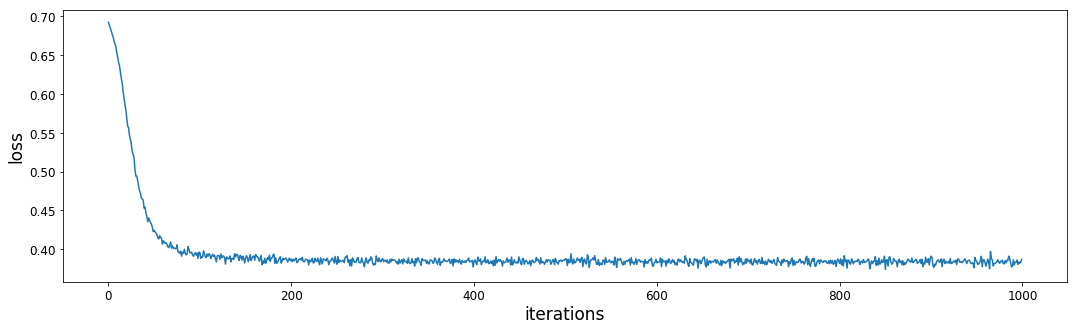

In [214]:
model = ClassificationMDN(n_input=2, n_hidden_units=10, n_hidden_layers=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
trainer = Trainer(model, optimizer, verbose=True, classification=True)

n_epochs = 100
n_minibatch = int(ntrain / 10)

# train with training data
loss_trace = trainer.train(sx_zt, m, n_epochs=n_epochs, n_minibatch=n_minibatch)
plt.plot(loss_trace)
plt.ylabel('loss')
plt.xlabel('iterations');

## Prior checks

In [62]:
prior_probs = np.arange(0.1, 1., 0.2)
post_probs_mean = np.zeros_like(prior_probs)
sx_test_m1 = stats_poi_test[:100]
sx_test_m2 = stats_nb_test[:100]
n_rounds = 3

for ii, pp in enumerate(prior_probs): 
    idx = int(pp * 100)
    # up to idx for m1
    d1 = sx_test_m1[:idx, ]
    # from idx to end for m2
    d2 = sx_test_m2[idx:, ]
    test_set = np.vstack((d1, d2))
    model_prior = MyModelPrior.from_dictionary({'type': 'multinomial', 'kwargs': {'n': 1, 'p': [pp, 1 - pp]}})
    
    # rejection sampling 
    ppoi = np.zeros(test_set.shape[0])
    n_simulations = 0
    for jj in tqdm.tqdm(range(test_set.shape[0])): 
        sxo = test_set[jj, ]

        # We plug all the ABC options together
        abc = ABCSMC(
            models, parameter_priors, 
            MyDist(), model_prior=model_prior)

        # and we define where to store the results
        db_path = ("sqlite:///" +
                   os.path.join(tempfile.gettempdir(), "test.db"))
        abc_id = abc.new(db_path, {"y": sxo})
        history = abc.run(minimum_epsilon=0.05, max_nr_populations=n_rounds)
        model_probabilities = history.get_model_probabilities().as_matrix()
        n_simulations += history.total_nr_simulations
        try: 
            ppoi[jj] = model_probabilities[0, model_probabilities.shape[0] - 1]
        except:
            ppoi[jj] = model_probabilities[model_probabilities.shape[0] - 1, 0]

    print(n_simulations)
       
    post_probs_mean[ii] = ppoi.mean()

  0%|          | 0/50 [00:00<?, ?it/s]INFO:Epsilon:initial epsilon is 60.704800000000006
INFO:History:Start <ABCSMC(id=432, start_time=2018-05-23 14:05:48.519746, end_time=None)>
INFO:ABC:t:0 eps:60.704800000000006
INFO:ABC:t:1 eps:40.77972499999996
INFO:ABC:t:2 eps:28.176140453784363
INFO:History:Done <ABCSMC(id=432, start_time=2018-05-23 14:05:48.519746, end_time=2018-05-23 14:05:50.276840)>
  2%|▏         | 1/50 [00:01<01:32,  1.90s/it]INFO:Epsilon:initial epsilon is 56.090925000000006
INFO:History:Start <ABCSMC(id=433, start_time=2018-05-23 14:05:50.422967, end_time=None)>
INFO:ABC:t:0 eps:56.090925000000006
INFO:ABC:t:1 eps:28.08364999999999
Process Process-8296:
  File "/Users/Jan/anaconda3/envs/pytorch/lib/python3.6/site-packages/pyabc/smc.py", line 447, in _generate_valid_proposal
    theta_ss = self.transitions[m_ss].rvs()
Process Process-8294:
Process Process-8290:
Process Process-8292:
Process Process-8291:
Process Process-8293:
Process Process-8289:
Process Process-8295:
Tr

KeyboardInterrupt: 

  File "/Users/Jan/anaconda3/envs/pytorch/lib/python3.6/site-packages/pyabc/smc.py", line 604, in simulate_one
    par = self._generate_valid_proposal(t, m, p)

  File "/Users/Jan/anaconda3/envs/pytorch/lib/python3.6/site-packages/pyabc/smc.py", line 507, in _calc_proposal_weight
    pd.Series(dict(theta_ss)))
  File "/Users/Jan/anaconda3/envs/pytorch/lib/python3.6/site-packages/pyabc/smc.py", line 606, in simulate_one
    model_probabilities)
  File "/Users/Jan/anaconda3/envs/pytorch/lib/python3.6/site-packages/pyabc/sampler/multicore_evaluation_parallel.py", line 24, in work
    new_sim = simulate_one()
  File "/Users/Jan/anaconda3/envs/pytorch/lib/python3.6/site-packages/pyabc/smc.py", line 518, in _calc_proposal_weight
    / normalization)
  File "/Users/Jan/anaconda3/envs/pytorch/lib/python3.6/site-packages/pyabc/sampler/multicore_evaluation_parallel.py", line 24, in work
    new_sim = simulate_one()
  File "/Users/Jan/anaconda3/envs/pytorch/lib/python3.6/site-packages/pyabc/smc.p

  File "/Users/Jan/anaconda3/envs/pytorch/lib/python3.6/site-packages/pandas/core/generic.py", line 4321, in fillna
    elif not is_list_like(value):
KeyboardInterrupt
  File "/Users/Jan/anaconda3/envs/pytorch/lib/python3.6/site-packages/pandas/core/nanops.py", line 128, in f
    result = alt(values, axis=axis, skipna=skipna, **kwds)
  File "<string>", line 2, in <module>
  File "/Users/Jan/anaconda3/envs/pytorch/lib/python3.6/site-packages/numpy/lib/stride_tricks.py", line 249, in broadcast_arrays
    shape = _broadcast_shape(*args)
  File "/Users/Jan/anaconda3/envs/pytorch/lib/python3.6/site-packages/pandas/core/nanops.py", line 331, in nansum
    values, mask, dtype, dtype_max = _get_values(values, skipna, 0)
  File "/Users/Jan/anaconda3/envs/pytorch/lib/python3.6/site-packages/pandas/core/dtypes/inference.py", line 266, in is_list_like
    return (isinstance(obj, Iterable) and
KeyboardInterrupt
  File "/Users/Jan/anaconda3/envs/pytorch/lib/python3.6/site-packages/pandas/core/nanops

In [ ]:
stats_poi.shape, data_poi.shape

In [ ]:
sx_test_m1 = stats_poi_test[:100]
sx_test_m2 = stats_nb_test[:100]
prior_probs = np.arange(0.1, 1., 0.1)
post_probs_mean_de = np.zeros_like(prior_probs)

for ii, pp in enumerate(prior_probs): 
    idx = int(pp * 100)
    # up to idx for m1
    d1 = sx_test_m1[:idx, ]
    # from idx to end for m2
    d2 = sx_test_m2[idx:, ]
    test_set = np.vstack((d1, d2))
    
    # learn new abc model with given prior on training set 
    loop_model = ClassificationMDN(n_input=2, n_hidden_units=10, n_hidden_layers=1)
    optimizer = torch.optim.Adam(loop_model.parameters(), lr=0.01)
    trainer = Trainer(loop_model, optimizer, verbose=True, classification=True)

    # train with training data
    ntrain = stats_poi.shape[0]  # training size 
    training_set_idx = int(pp * ntrain)  # set prior index 
    sx_loop = np.vstack((stats_poi[:training_set_idx, ], stats_nb[training_set_idx:, ]))
    m_loop = np.hstack((np.zeros(training_set_idx), np.ones(ntrain - training_set_idx))).astype(int).tolist()
    
    sx_loop_zt, loop_norm = normalize(sx_loop)

    n_epochs = 10
    n_minibatch = int(ntrain / 100)

    loss_trace = trainer.train(sx_loop_zt, m_loop, n_epochs=n_epochs, n_minibatch=n_minibatch)
    # predict with abc model 
    test_data_zt, _ = normalize(test_set, loop_norm)
    p = loop_model.predict(test_data_zt)[:, 0]
    post_probs_mean_de[ii] = p.mean()

In [ ]:
plt.plot(np.arange(.1, 1., .2), post_probs_mean, 'o-')
plt.plot(prior_probs, post_probs_mean_de, 'o-')
plt.plot(prior_probs, prior_probs)

## Posterior checks

In [195]:
sx_test = np.vstack((stats_poi_test, stats_nb_test))
sx_test_zt, training_norm = normalize(sx_test, training_norm)

In [196]:
ppoi_hat = model.predict(sx_test_zt)[:, 0]

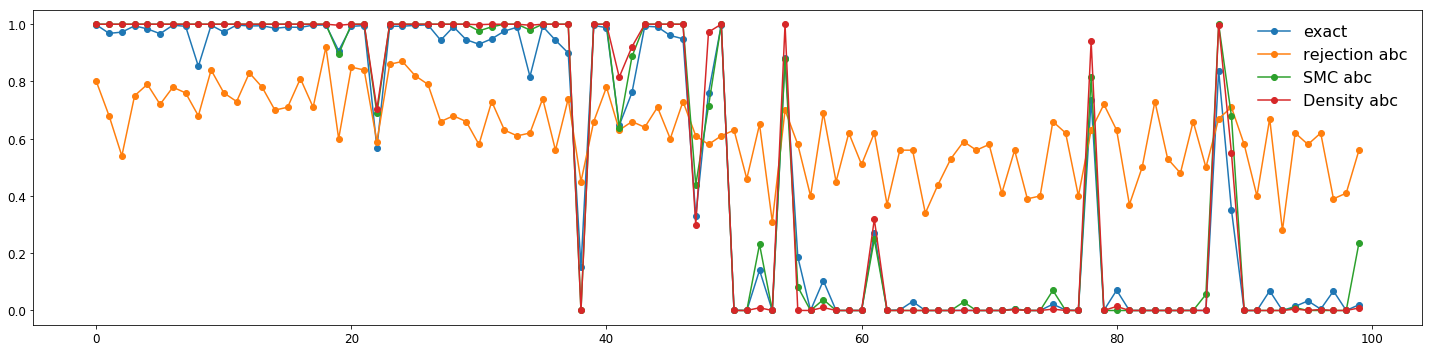

In [197]:
plt.figure(figsize=(20, 5))
plt.plot(ppoi_exact, '-o', label='exact')
plt.plot(phat_rej[:, 0], '-o', label='rejection abc')
plt.plot(phat_smc[:, 0], '-o', label='SMC abc')
plt.plot(ppoi_hat, '-o', label='Density abc')
plt.legend(fontsize=16)
plt.tight_layout()

In [215]:
np.mean(np.abs(ppoi_exact - phat_rej[:, 0]))

0.35693459511704534

In [216]:
np.mean(np.abs(ppoi_exact - phat_smc[:, 0]))

0.031569154850361887

In [217]:
np.mean(np.abs(ppoi_exact - ppoi_hat))

0.035333902401126618

In [212]:
test_set = np.vstack((stats_poi_test, stats_nb_test))
d = dict(x_test=xtest, sx_test=test_set, x=x, sx=sx, 
         ppoi_exact=ppoi_exact, 
         ppoi_hat=ppoi_hat, ns_hat=n, 
         ppoi_smc=phat_smc[:, 0], ns_smc=ns_smc,
         ppoi_rej=phat_rej[:, 0], ns_rej=ns_rej)
#          prior_probs=prior_probs, 
#          post_probs_mean_hat=post_probs_mean_de, 
#          post_probs_mean_smc=post_probs_mean)

In [213]:
fn = time_stamp + '_modelposterior_comparison_exact_DE_SMC_ns{}_ntest{}.p'.format(sample_size, ntest)
with open(os.path.join('../data', fn), 'wb') as outfile: 
    pickle.dump(d, outfile, protocol=pickle.HIGHEST_PROTOCOL)